<a href="https://colab.research.google.com/github/Hamzeluie/finger_hand_number_prediction/blob/main/finger_number_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [3]:
import os
import numpy as np
from skimage import io
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms
from torchvision.models.vgg import vgg19
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

#Parameters

In [20]:
path_train = "./train"
path_test = "./test"
image_size = 128
BATCH = 60
n_class = 6
EPOCHS = 2
device = "cuda"

#Dataset

In [13]:
class FingerNumber(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transformer = transform
        self.data = None
        self.label = None
        self.names = None
        self.__make_label()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        x = self.data[item]
        y = self.label[item]
        name = self.names[item]
        image = io.imread(x)
        image = np.expand_dims(image, -1).repeat(3, axis=-1)

        if self.transformer != None:
            image = self.transformer(image)
        return name, image, torch.tensor(y, dtype=torch.int)

    def __make_label(self):
        x = []
        y = []
        names = []
        for p in os.listdir(self.path):
            names.append(p)
            x.append(os.path.join(self.path, p))
            y.append(int(p.split("_")[-1][:-4]))
        self.data = x
        self.label = y
        self.names = names

#Some Tools

In [56]:
def show_tensor_images(image_tensor, targets, num_images=25, ncol=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    nrow = len(image_tensor) // ncol
    fig = plt.figure(figsize=(10, 7))
    for idx, (img_tensor, lbl) in enumerate(zip(image_tensor, targets)):
        img_tensor = (img_tensor + 1) / 2
        image_unflat = img_tensor.detach().cpu()
        image_grid = make_grid(image_unflat[:num_images], nrow=nrow, value_range=(0, 5))

        fig.add_subplot(nrow, ncol, idx + 1)
        plt.imshow(image_grid.permute(1, 2, 0).squeeze())
        plt.axis("off")
        plt.title(str(lbl))
    if show:
        plt.show()

In [7]:
def evaluation(model, criterion, val_dataloader):
    print(f"evaluation steps number {len(val_dataloader)}")
    classifier_correct = 0
    num_validation = 0
    classifier_val_loss = 0
    for img, lbl in val_dataloader:
        img = img.to(device)
        lbl = lbl.to(device)
        cur_batch_size = len(img)
        num_validation += cur_batch_size
        pred = model(img)
        classifier_val_loss += criterion(pred, lbl) * cur_batch_size
        classifier_correct += (pred.argmax(1) == lbl).float().sum()
    loss = classifier_val_loss.item() / num_validation
    acc = classifier_correct.item() / num_validation
    print(f"Test loss: {round(loss, 3)},"
    f"accuracy: {round(acc, 3)}")
    return loss, acc
     

#Model

In [60]:
trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor()])
train_set = FingerNumber(path_train, trans)
train_len = int(train_set.__len__() * .75)
test_len = int(train_set.__len__() * .25)

train_ds, val_ds = random_split(train_set, [train_len, test_len], generator=torch.Generator().manual_seed(45))


train_data_loader = DataLoader(train_ds, BATCH, drop_last=True)
val_data_loader = DataLoader(val_ds, BATCH, drop_last=True)


**Show Some Samples**

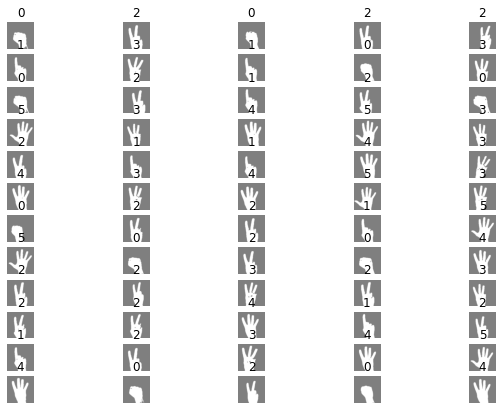

In [67]:
_, img, lbls = next(iter(train_data_loader))
lbls = lbls.cpu().detach().numpy()
show_tensor_images(img, lbls)
del img, lbls

In [11]:
model = vgg19(pretrained=True).to(device)
for p in model.features.parameters():
    p.requires_grad = False

in_features = model.classifier[-4].in_features
last_layer = nn.Linear(in_features=in_features, out_features=n_class).to(device)
model.classifier[-1] = last_layer

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#Train

In [12]:

status_step = 5

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())
schedual = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 200)
for e in range(EPOCHS):
    classifier_train_loss = 0
    classifier_correct = 0
    num_samples = 0
    for idx, (_, x, y) in enumerate(tqdm(train_data_loader)):
        x = x.to(device)
        y = y.to(torch.long)
        y = y.to(device)
        # y = nn.functional.one_hot(y, n_class)
        num_samples += len(x)
        opt.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        opt.step()
        schedual.step()
        classifier_train_loss += loss.item()
        classifier_correct += (pred.argmax(1) == y).float().sum()

        if idx % status_step == 0:
             print(f"Epoch {e + 1}/{EPOCHS} step/samples {idx}/{len(train_data_loader)} Training"
                      f" loss: {round(classifier_train_loss / num_samples, 3)}"
                      f" Accuracy: {round(classifier_correct.item() / num_samples, 3)}"
                      f", lr={round(opt.param_groups[-1]['lr'], 6)}")
             classifier_train_loss = 0
             classifier_correct = 0
             num_samples = 0

    torch.save({"model": model.state_dict()}, "./vgg19.pt")
    evaluation(model, criterion, val_data_loader)

    


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch 1/2 step/samples 0/96 Training loss: 0.032 Accuracy: 0.117, lr=0.001
Epoch 1/2 step/samples 5/96 Training loss: 0.027 Accuracy: 0.573, lr=0.000998
Epoch 1/2 step/samples 10/96 Training loss: 0.002 Accuracy: 0.973, lr=0.000993
Epoch 1/2 step/samples 15/96 Training loss: 0.002 Accuracy: 0.973, lr=0.000984
Epoch 1/2 step/samples 20/96 Training loss: 0.003 Accuracy: 0.963, lr=0.000973
Epoch 1/2 step/samples 25/96 Training loss: 0.001 Accuracy: 0.987, lr=0.000959
Epoch 1/2 step/samples 30/96 Training loss: 0.001 Accuracy: 0.983, lr=0.000942
Epoch 1/2 step/samples 35/96 Training loss: 0.0 Accuracy: 0.997, lr=0.000922
Epoch 1/2 step/samples 40/96 Training loss: 0.0 Accuracy: 1.0, lr=0.0009
Epoch 1/2 step/samples 45/96 Training loss: 0.0 Accuracy: 1.0, lr=0.000875
Epoch 1/2 step/samples 50/96 Training loss: 0.0 Accuracy: 1.0, lr=0.000848
Epoch 1/2 step/samples 55/96 Training loss: 0.0 Accuracy: 0.997, lr=0.000819
Epoch 1/2 step/samples 60/96 Training loss: 0.002 Accuracy: 0.977, lr=0.000

  0%|          | 0/96 [00:00<?, ?it/s]

Epoch 2/2 step/samples 0/96 Training loss: 0.002 Accuracy: 0.983, lr=0.000524
Epoch 2/2 step/samples 5/96 Training loss: 0.0 Accuracy: 1.0, lr=0.000484
Epoch 2/2 step/samples 10/96 Training loss: 0.0 Accuracy: 1.0, lr=0.000445
Epoch 2/2 step/samples 15/96 Training loss: 0.0 Accuracy: 1.0, lr=0.000406
Epoch 2/2 step/samples 20/96 Training loss: 0.001 Accuracy: 0.997, lr=0.000368
Epoch 2/2 step/samples 25/96 Training loss: 0.0 Accuracy: 1.0, lr=0.000331
Epoch 2/2 step/samples 30/96 Training loss: 0.001 Accuracy: 0.993, lr=0.000294
Epoch 2/2 step/samples 35/96 Training loss: 0.0 Accuracy: 1.0, lr=0.000259
Epoch 2/2 step/samples 40/96 Training loss: 0.001 Accuracy: 0.997, lr=0.000225
Epoch 2/2 step/samples 45/96 Training loss: 0.0 Accuracy: 1.0, lr=0.000194
Epoch 2/2 step/samples 50/96 Training loss: 0.0 Accuracy: 1.0, lr=0.000163
Epoch 2/2 step/samples 55/96 Training loss: 0.0 Accuracy: 1.0, lr=0.000136
Epoch 2/2 step/samples 60/96 Training loss: 0.0 Accuracy: 1.0, lr=0.00011
Epoch 2/2 st

#Inference

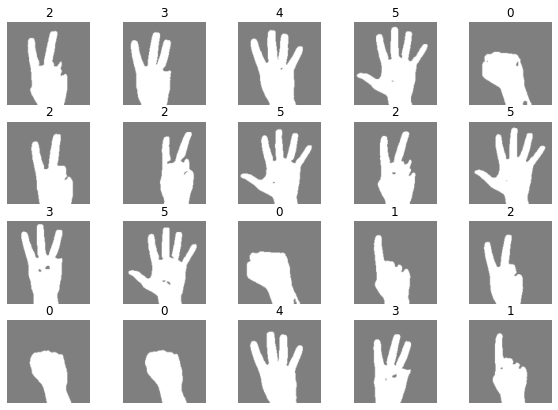

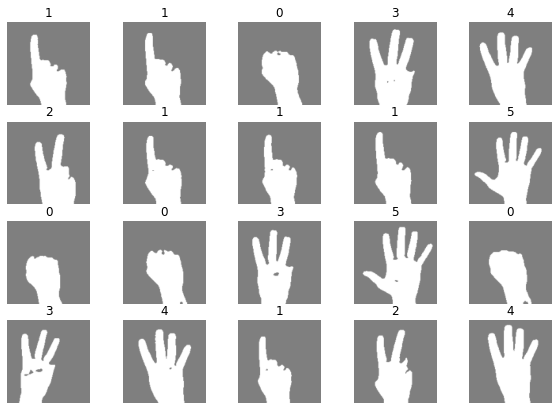

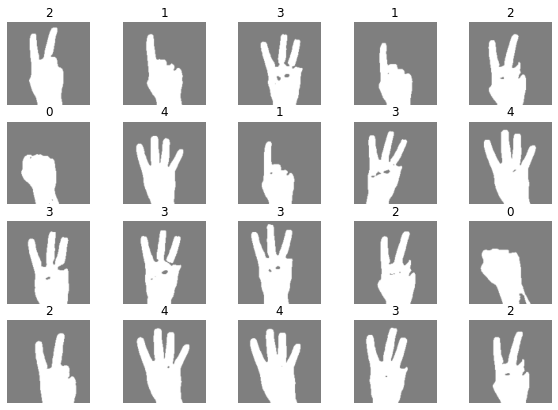

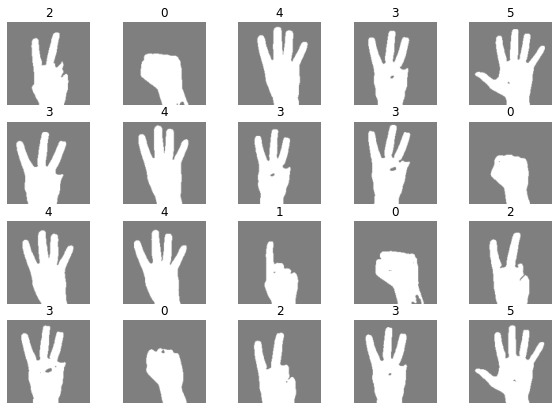

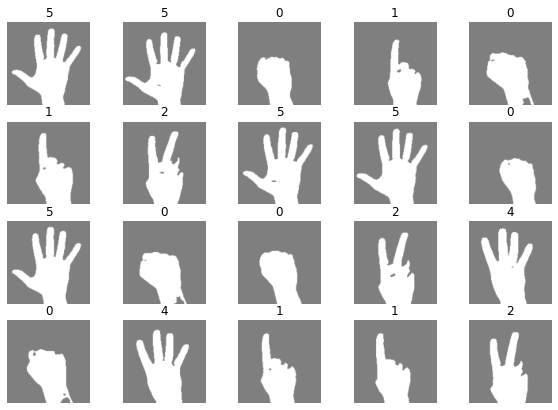

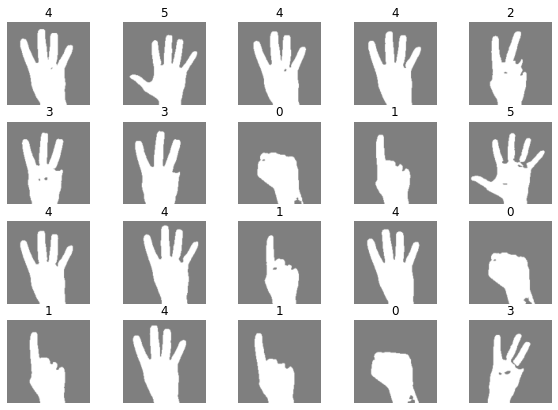

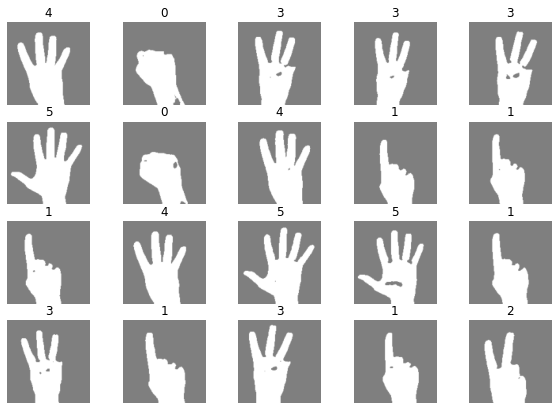

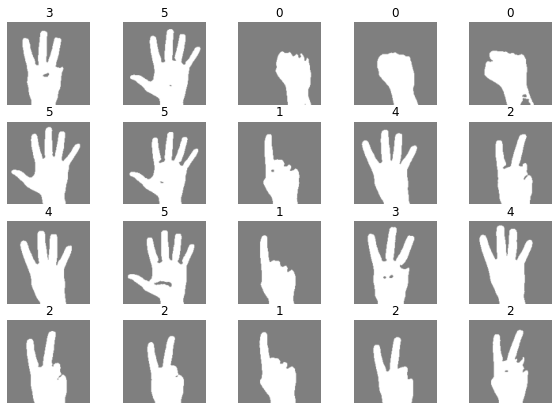

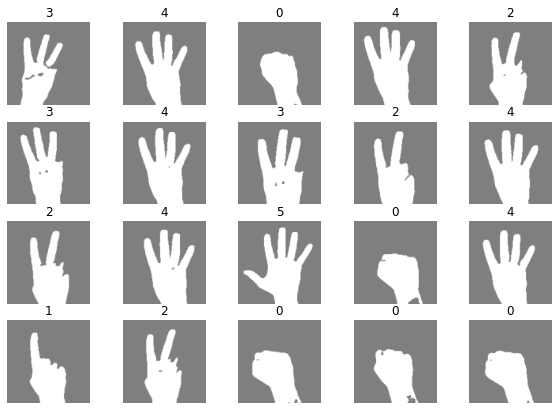

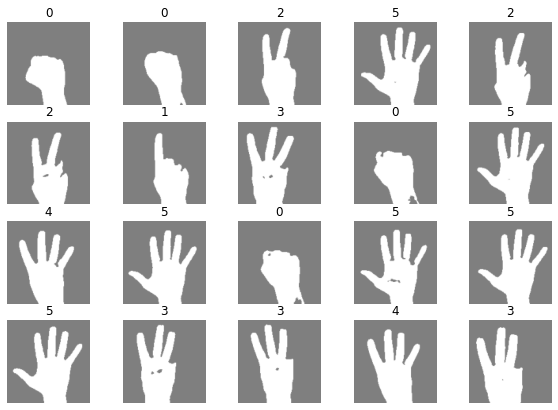

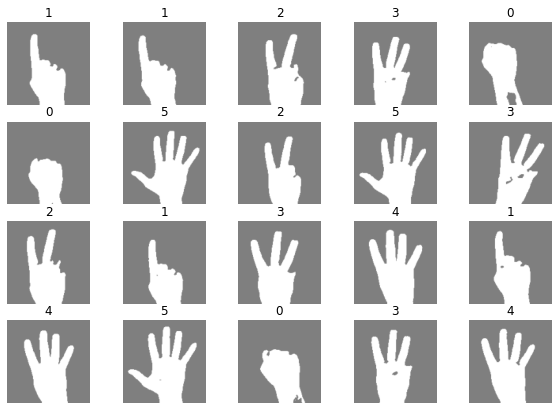

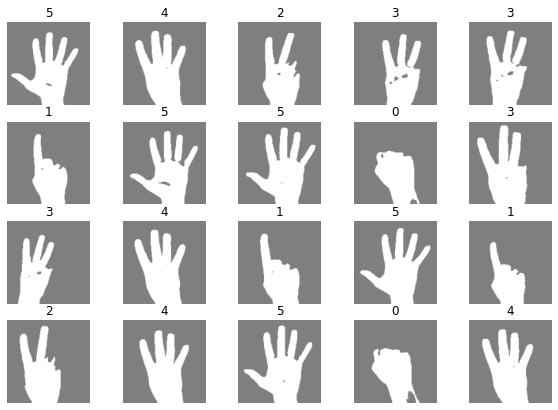

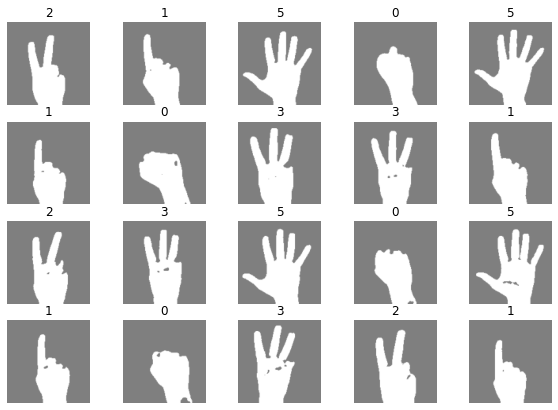

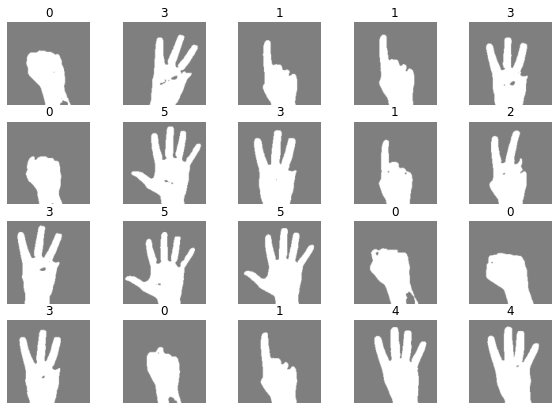

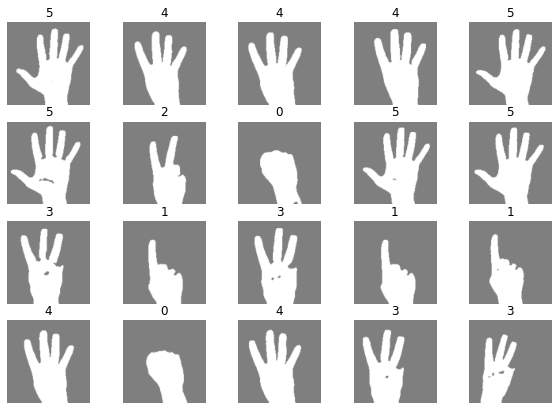

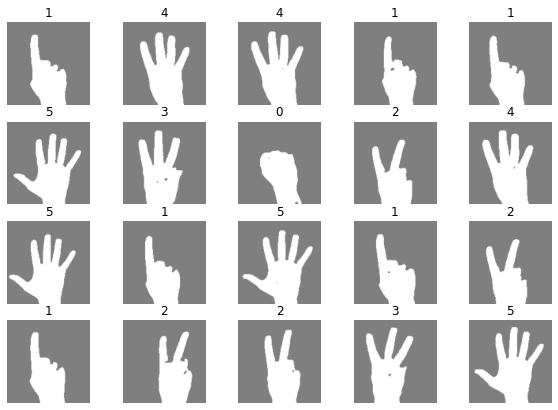

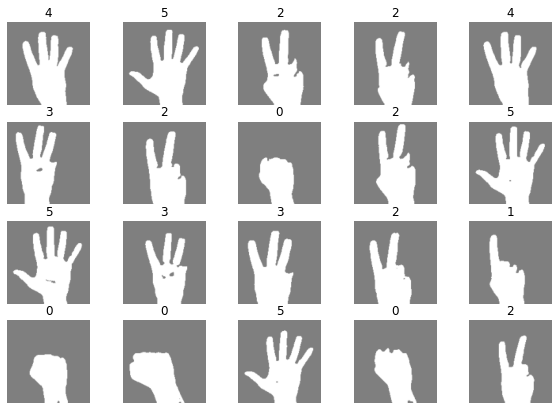

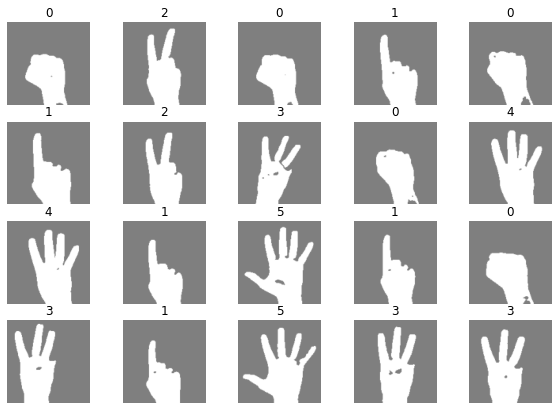

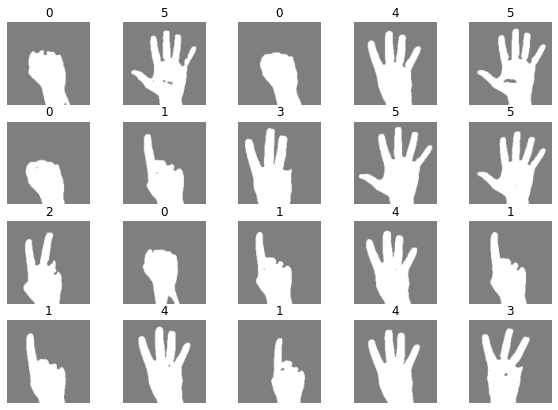

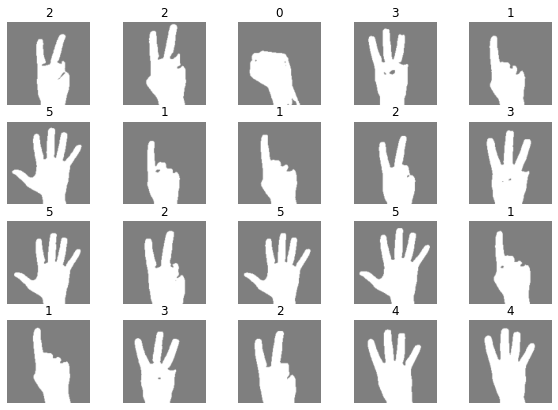

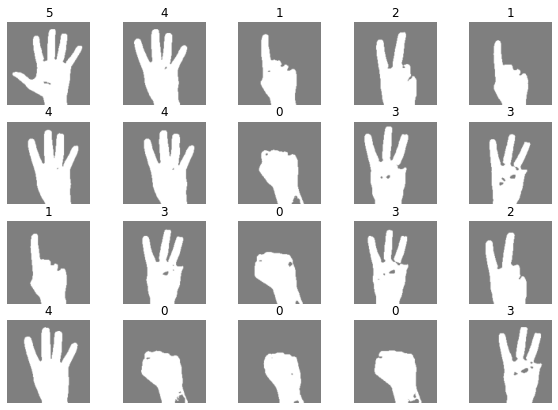

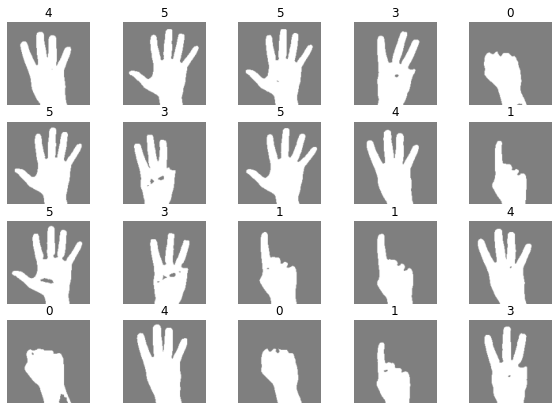

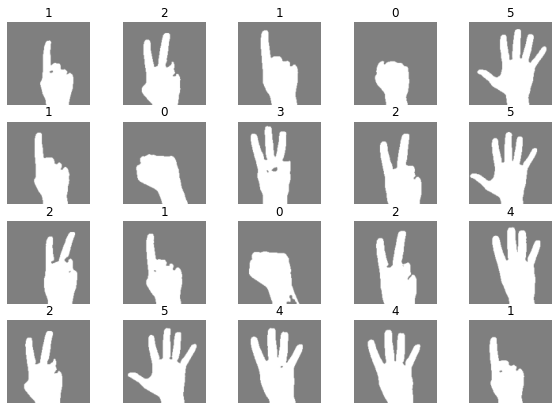

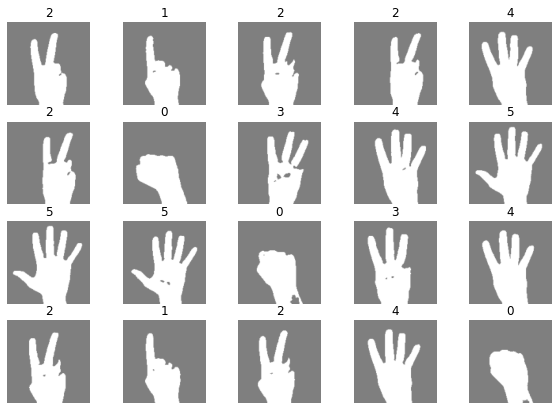

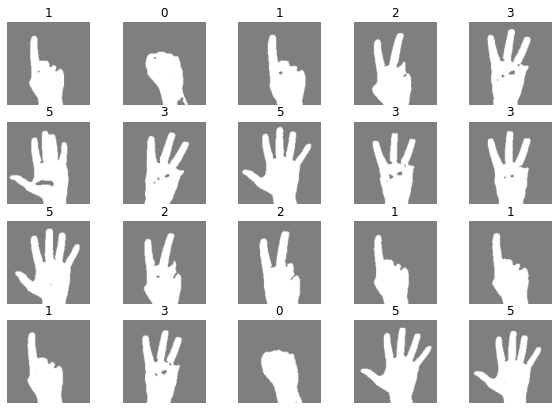

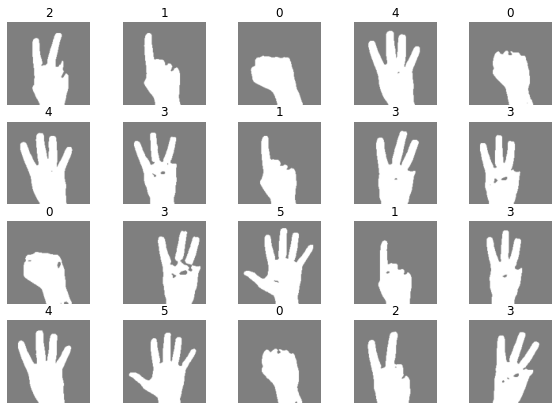

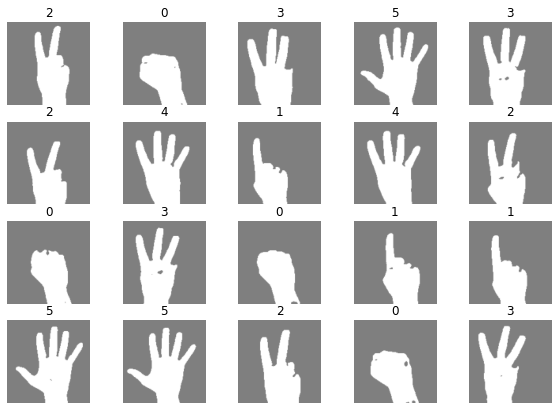

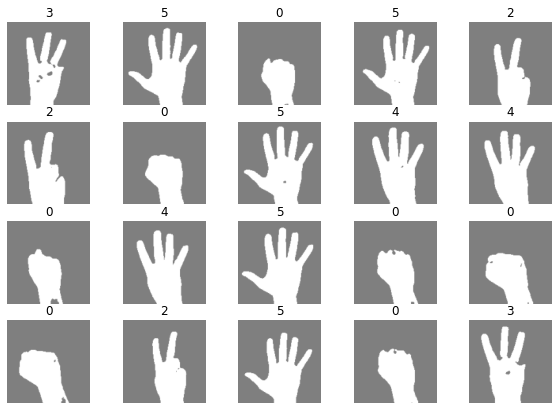

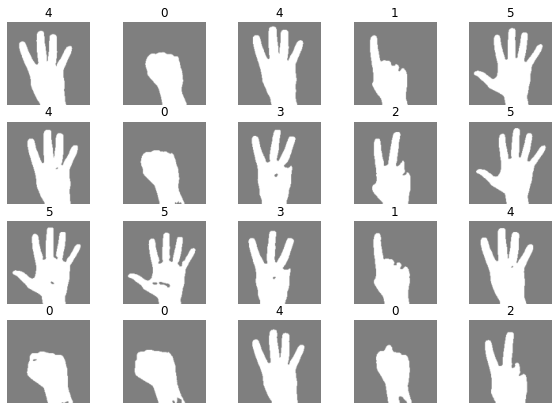

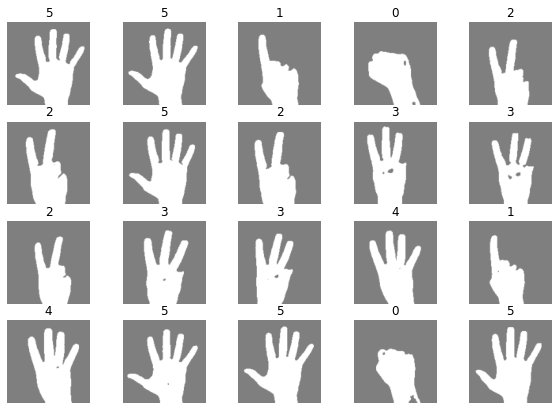

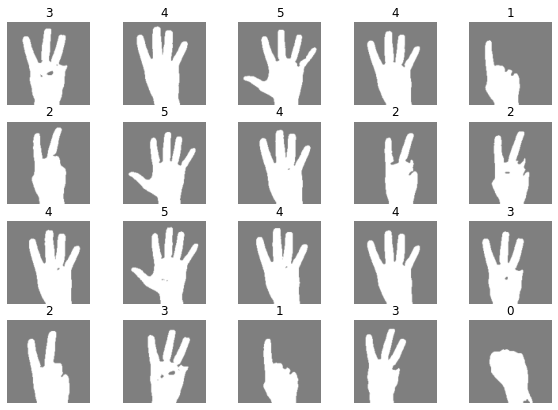

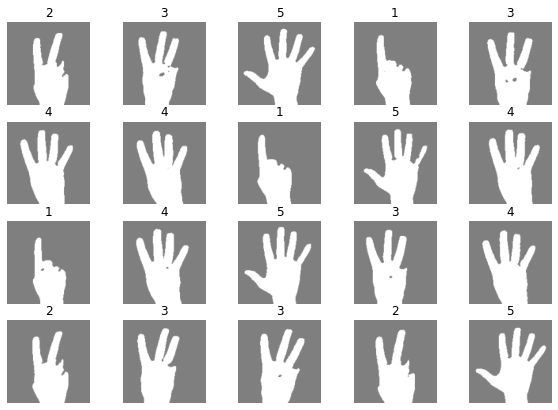

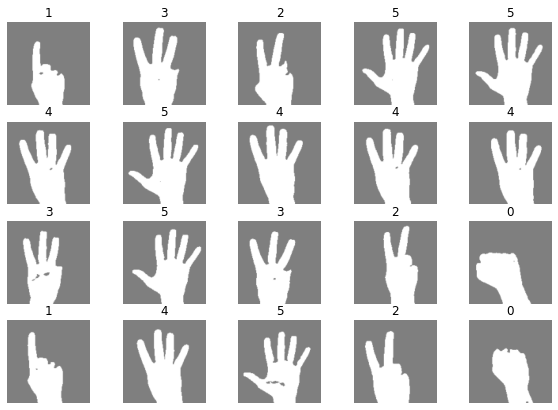

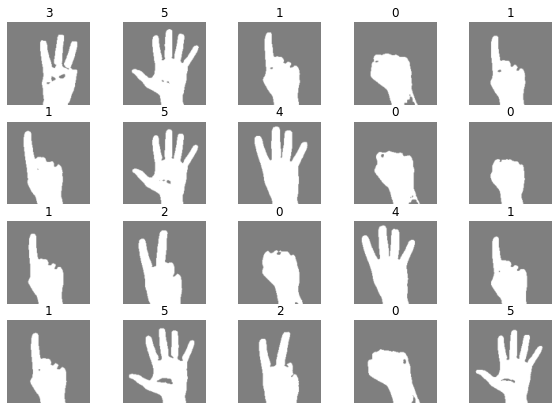

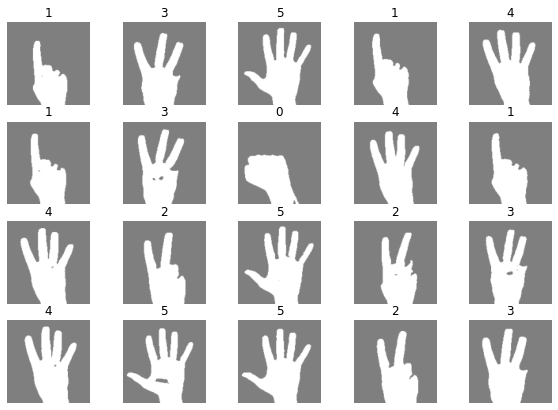

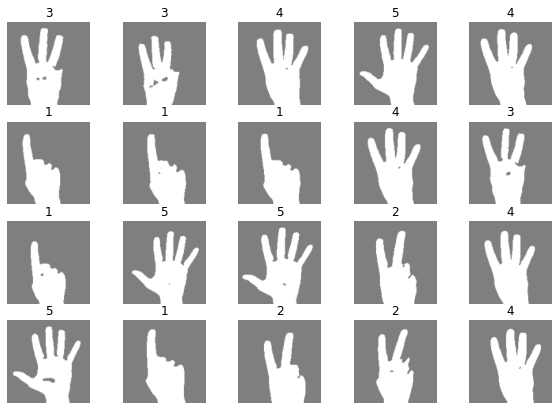

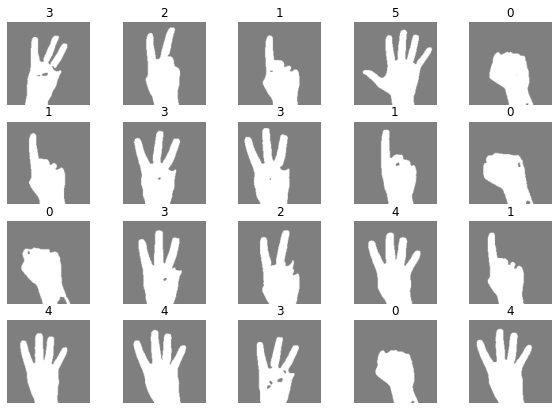

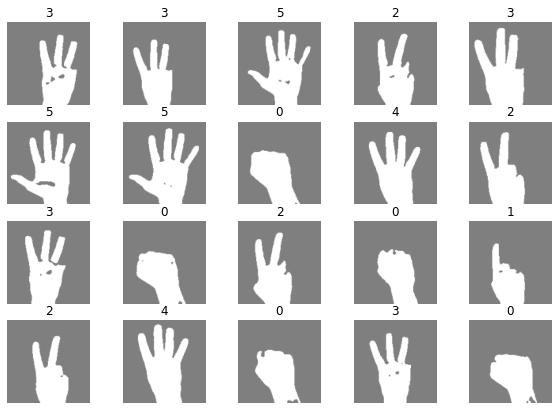

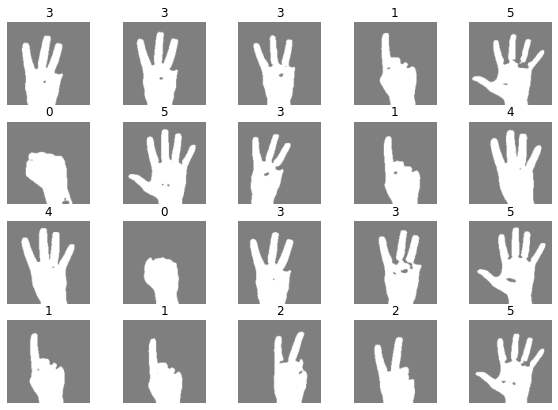

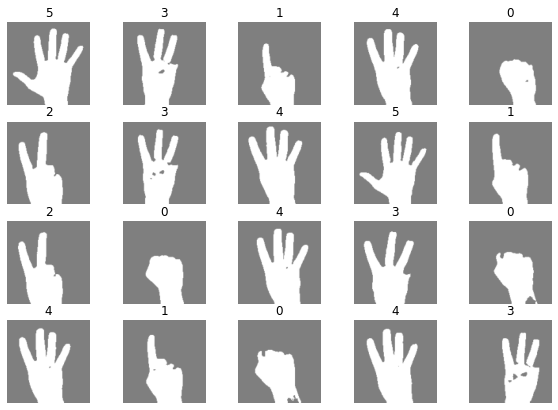

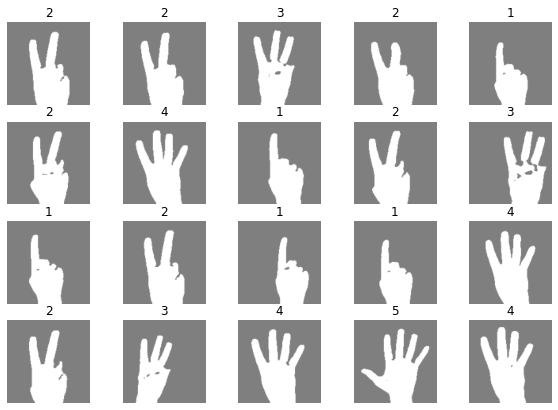

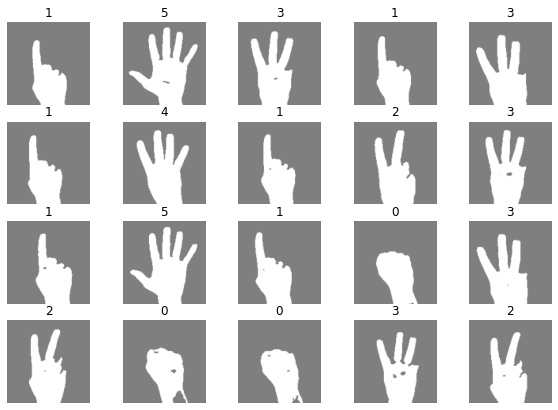

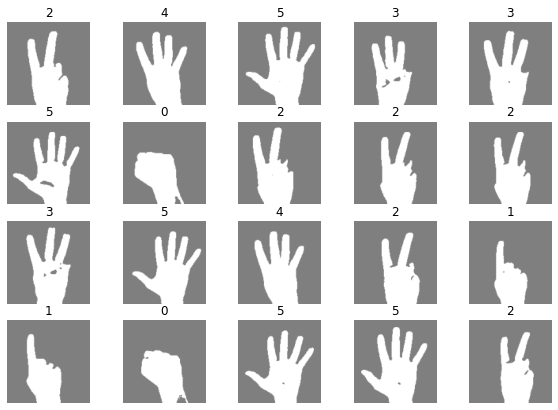

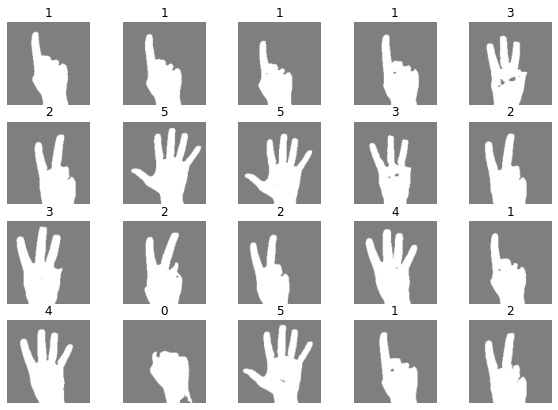

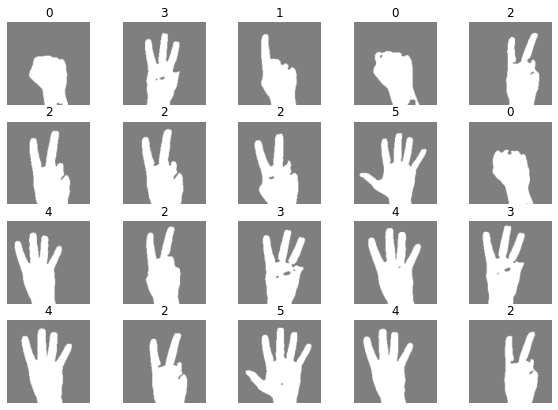

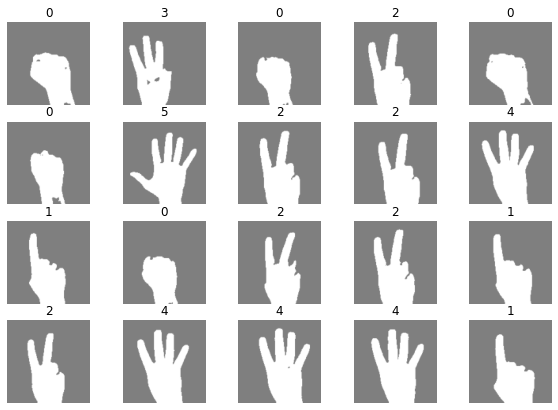

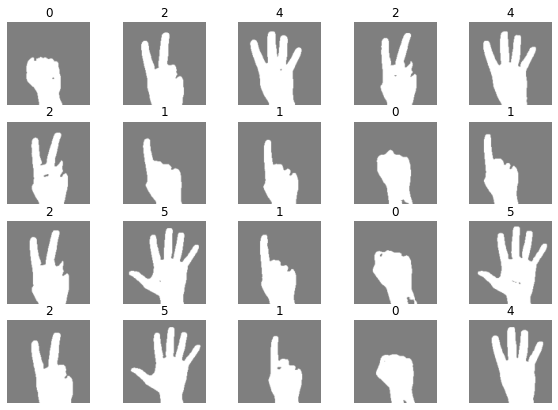

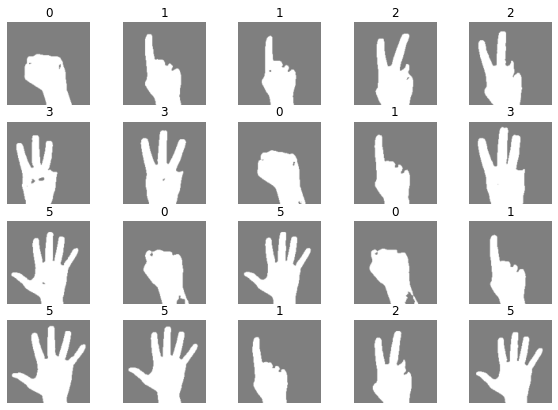

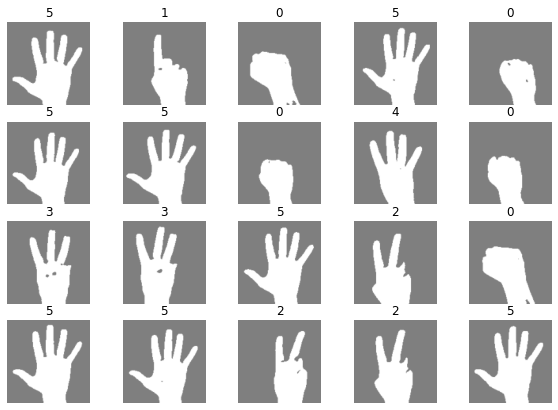

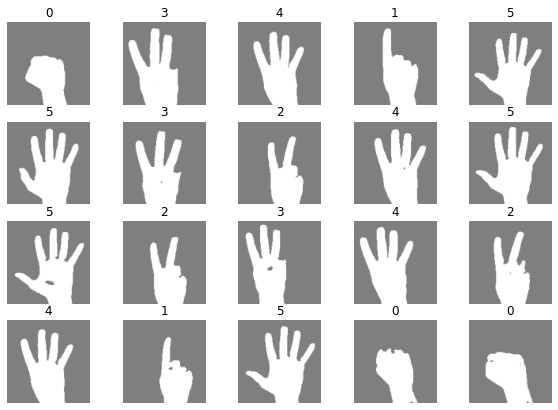

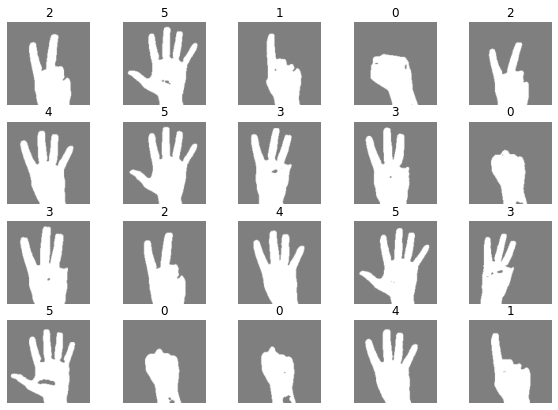

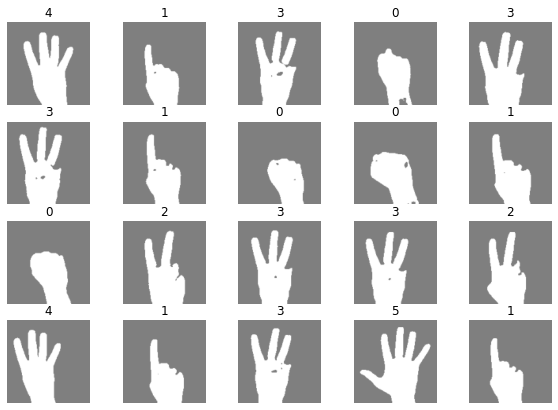

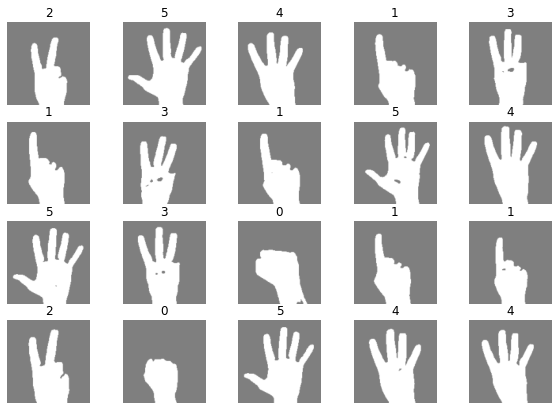

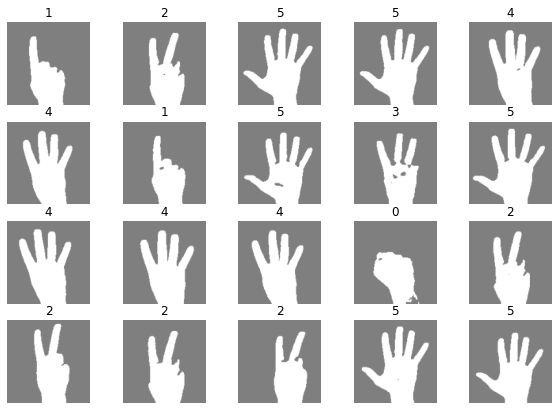

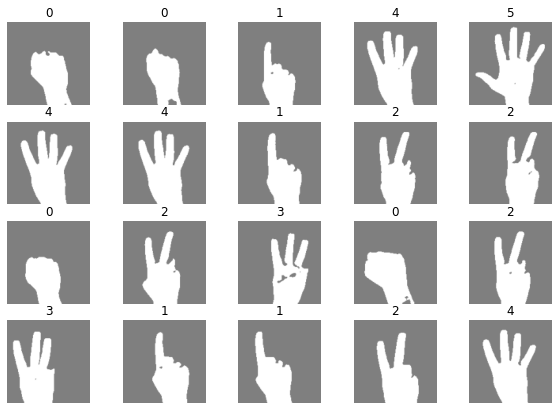

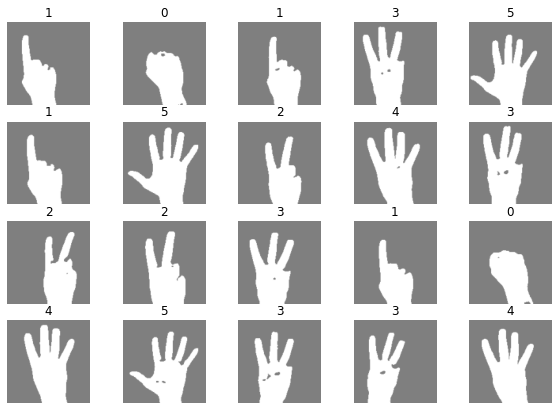

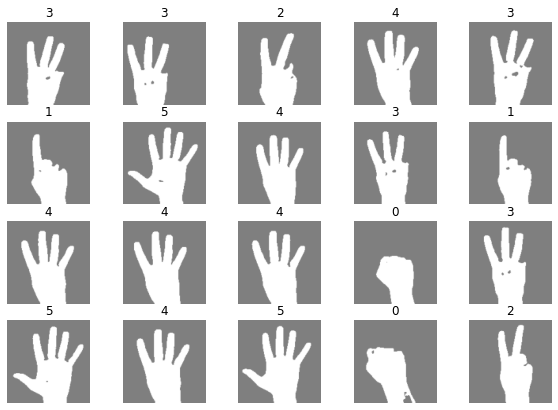

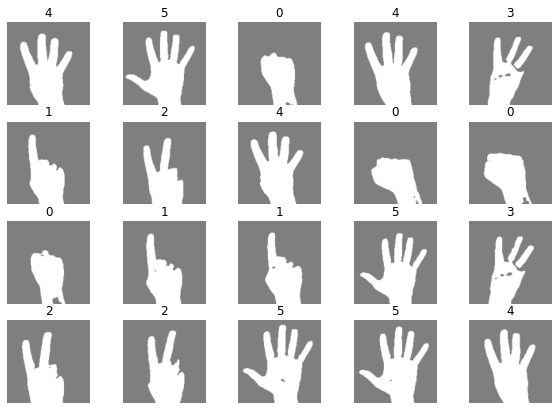

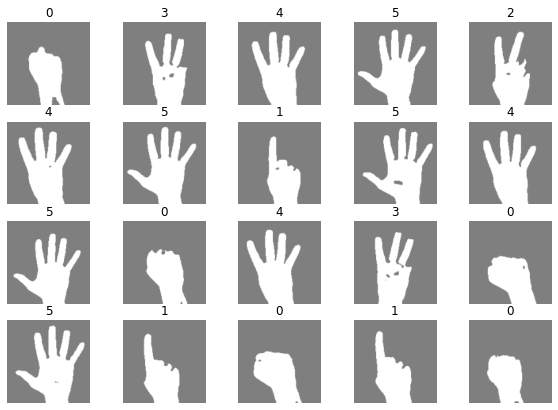

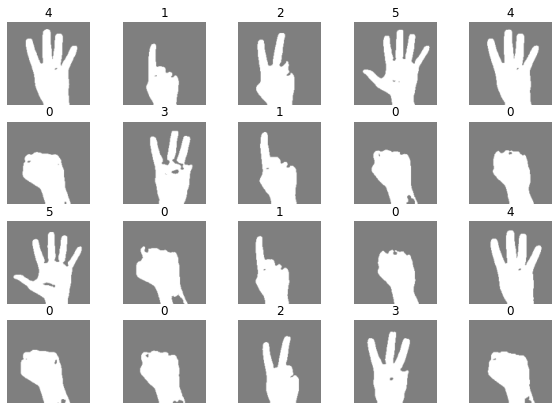

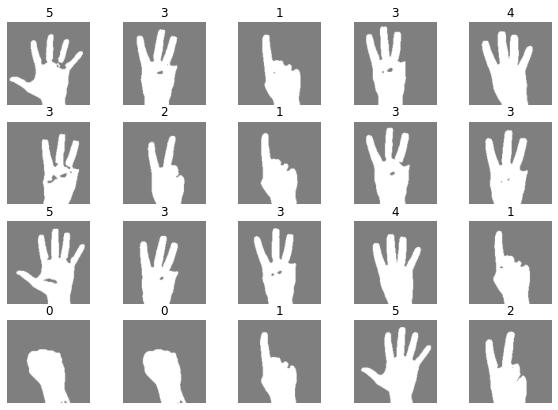

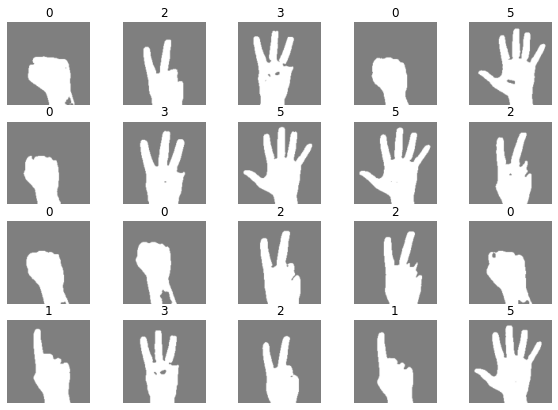

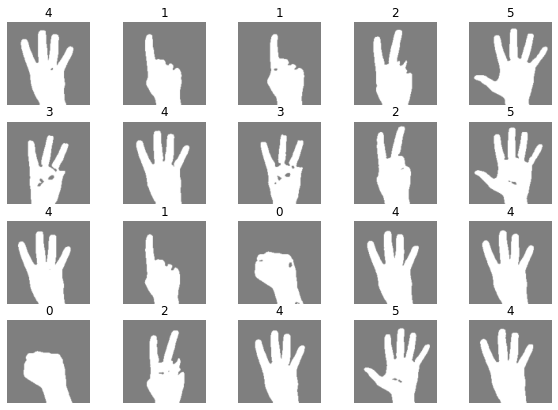

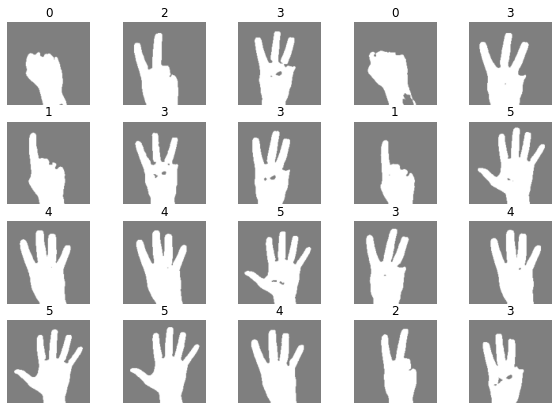

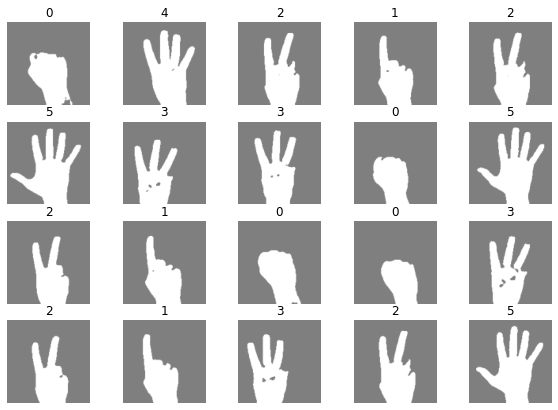

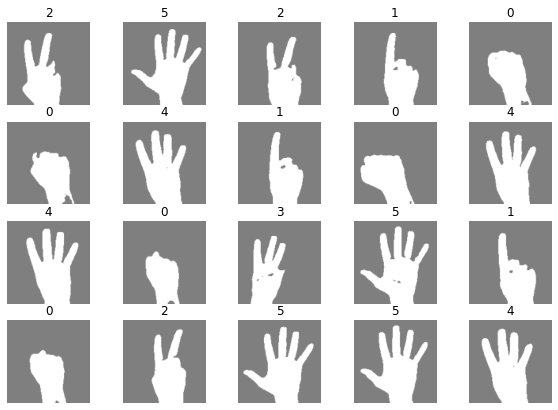

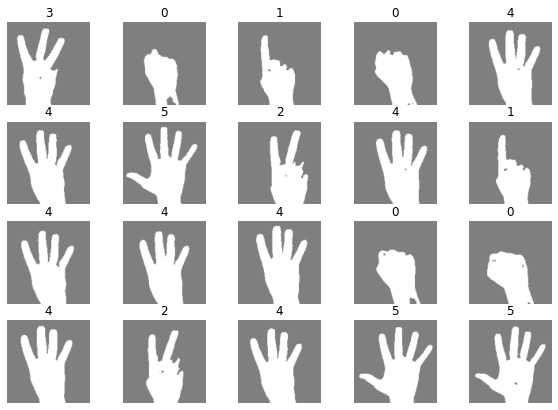

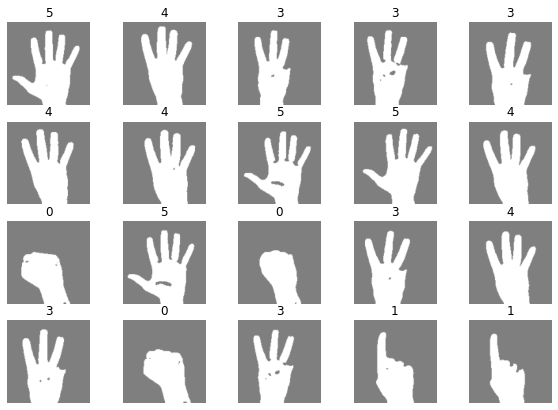

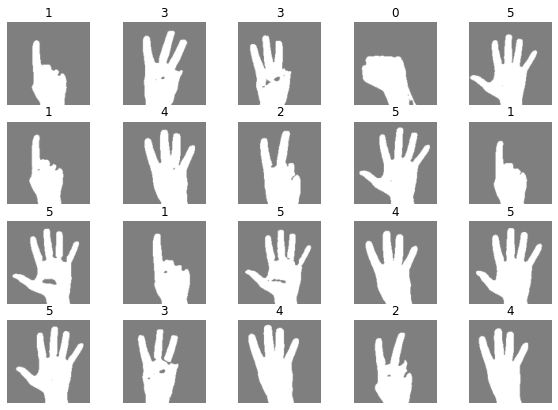

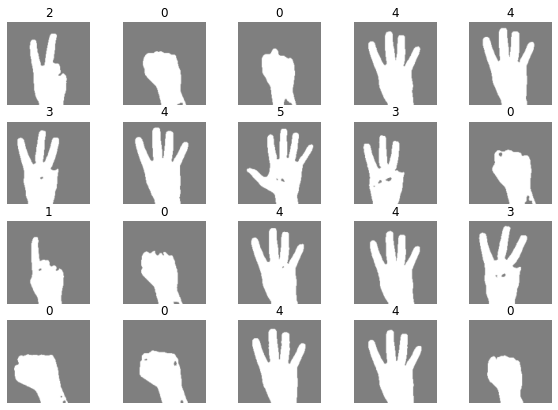

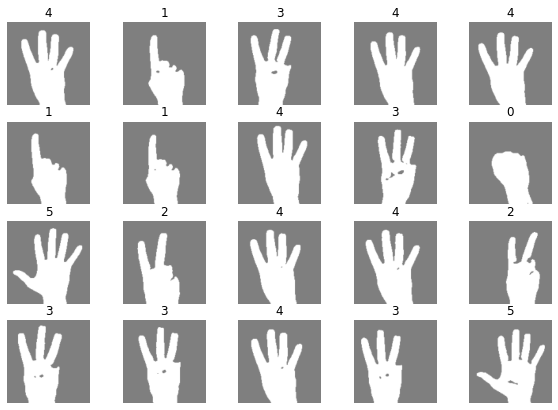

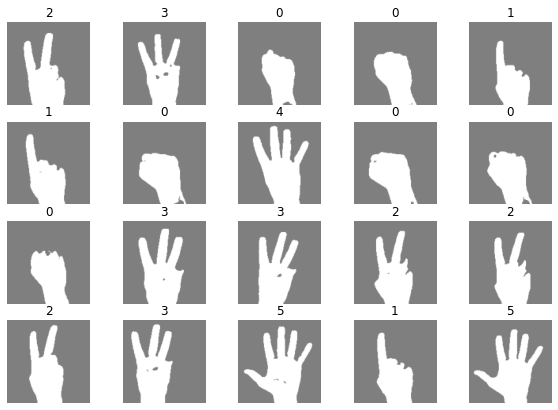

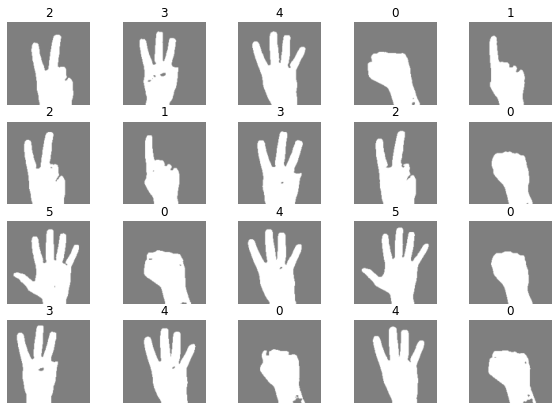

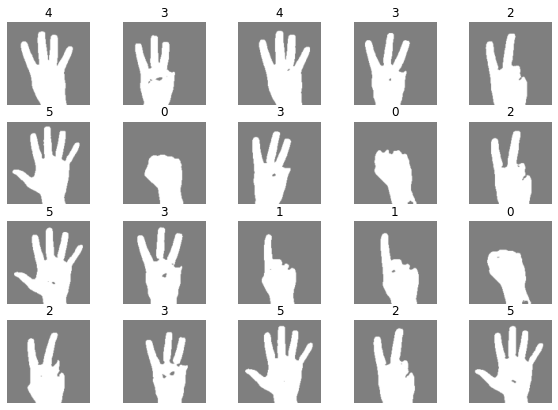

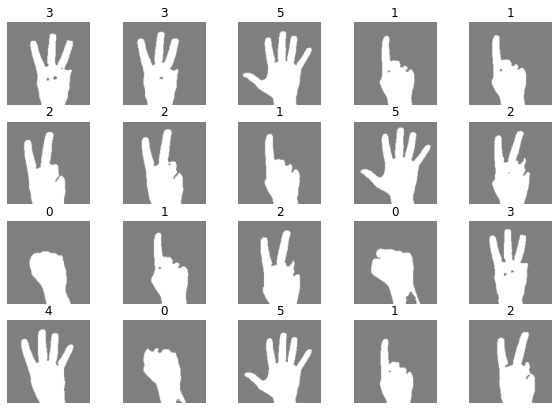

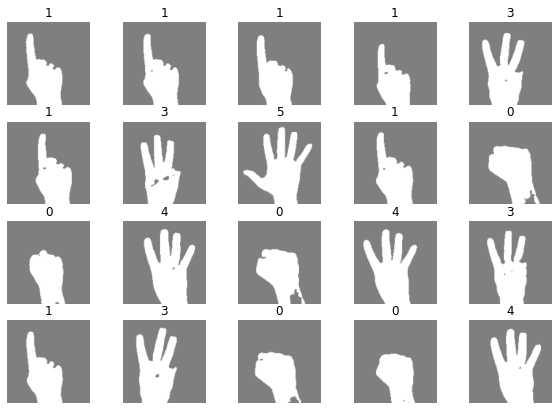

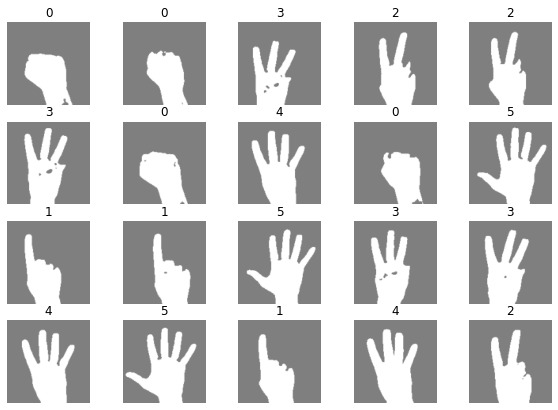

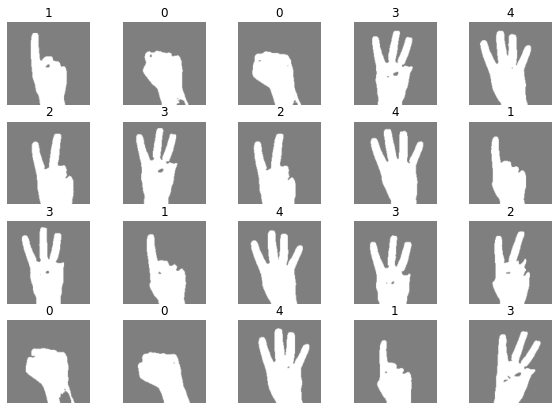

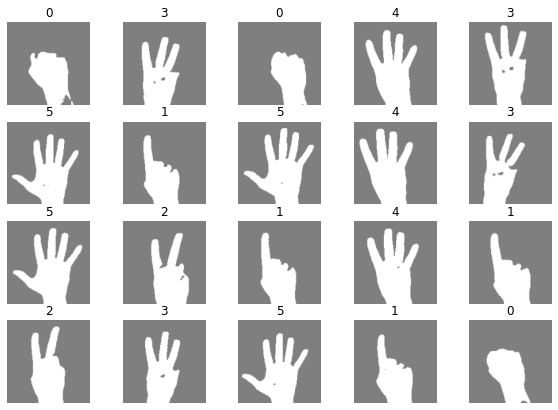

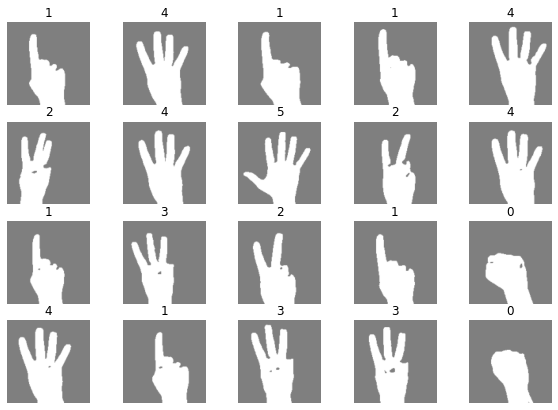

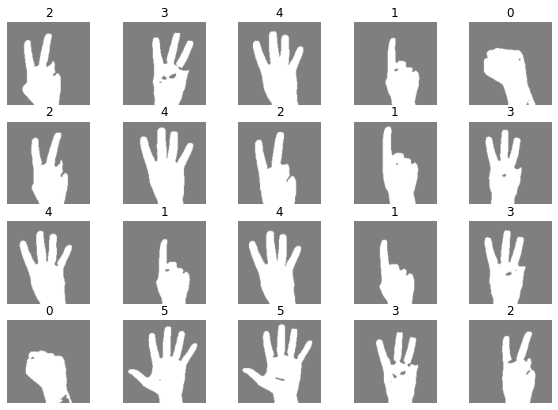

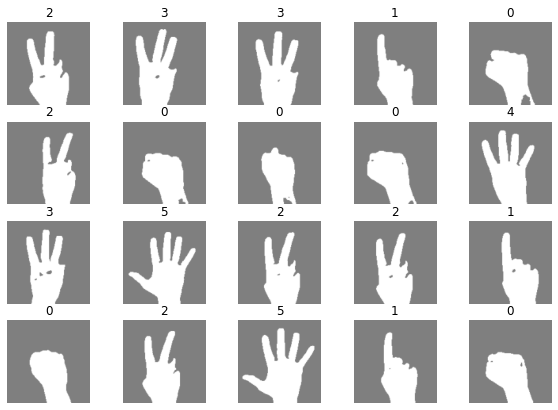

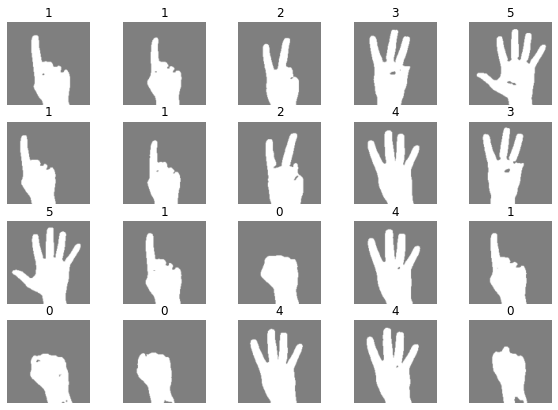

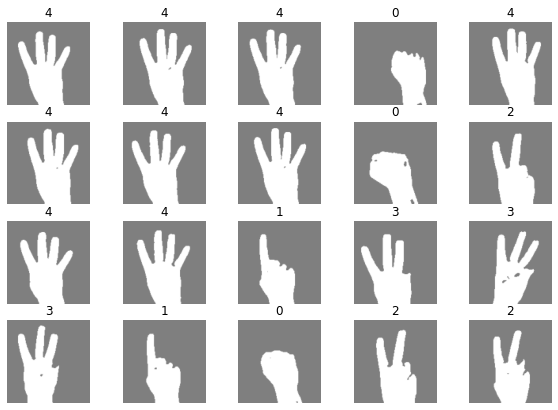

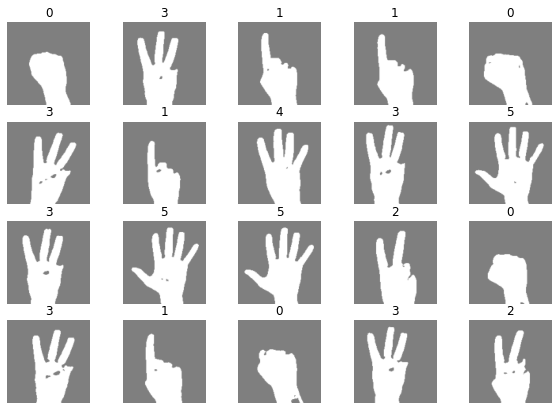

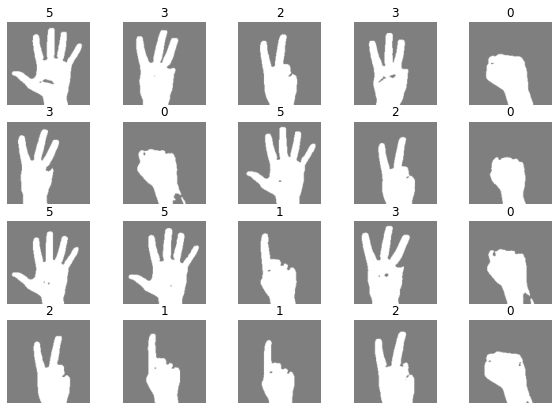

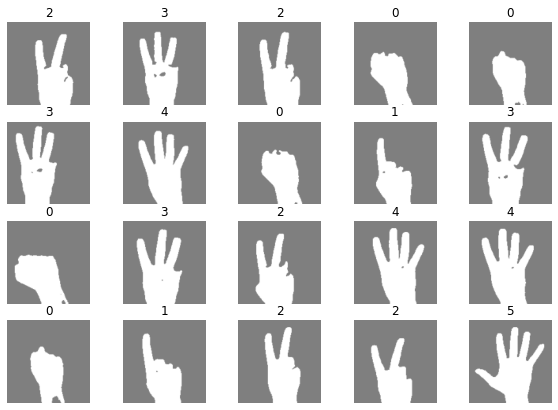

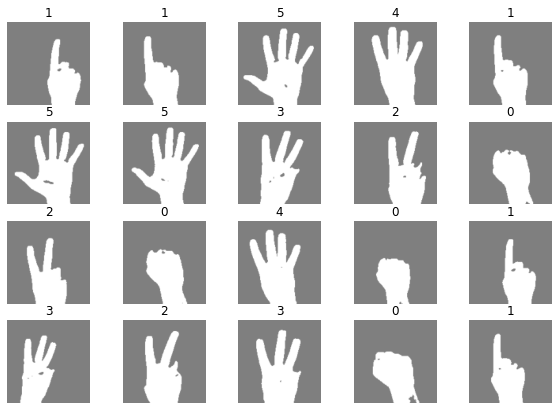

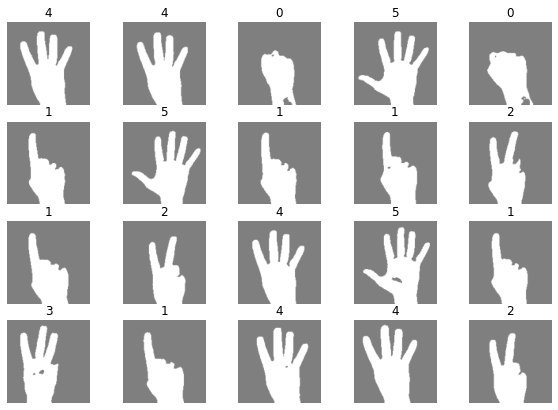

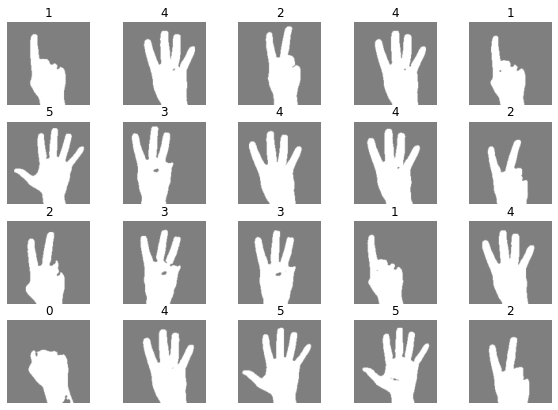

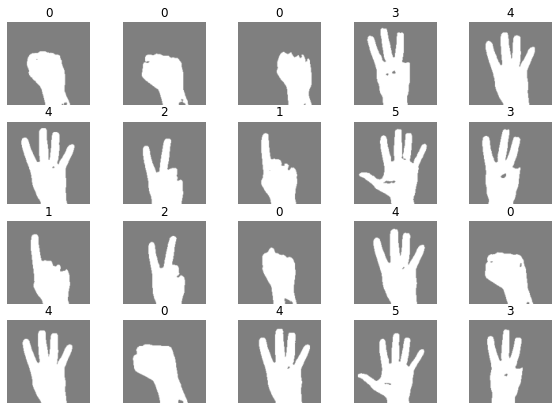

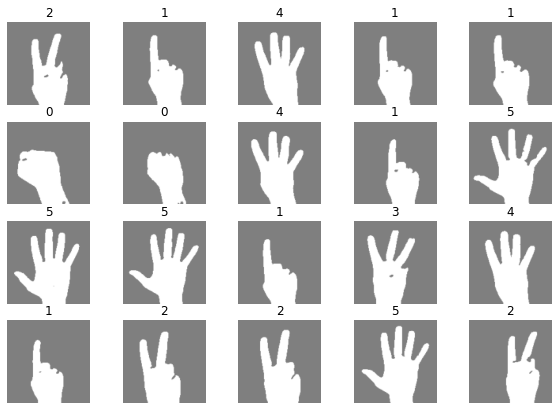

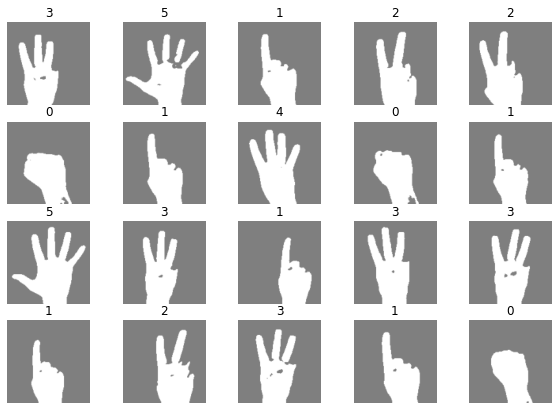

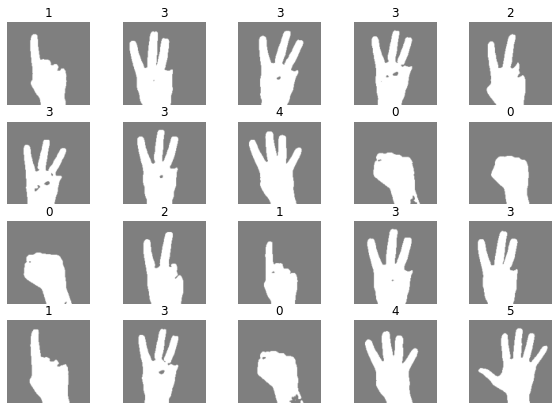

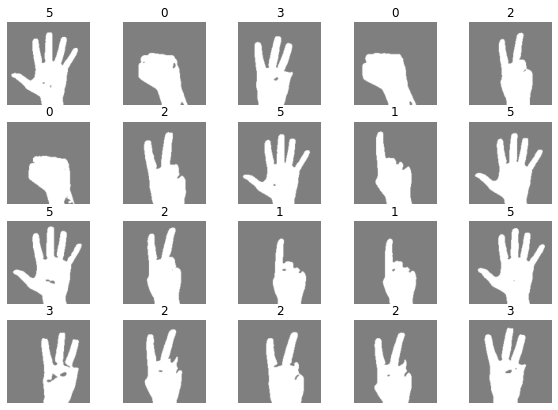

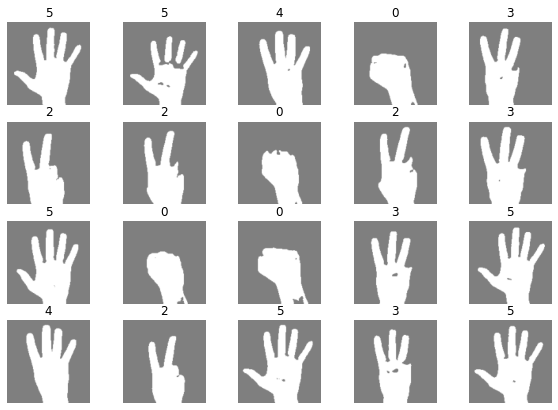

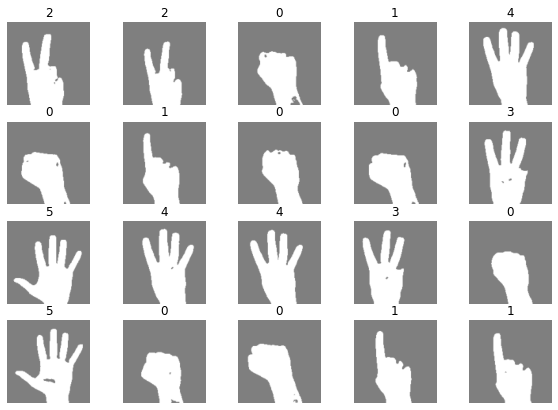

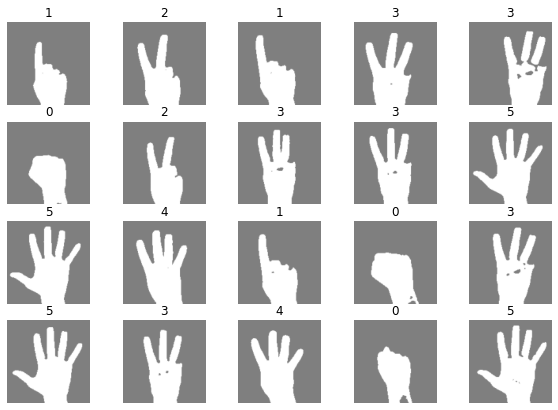

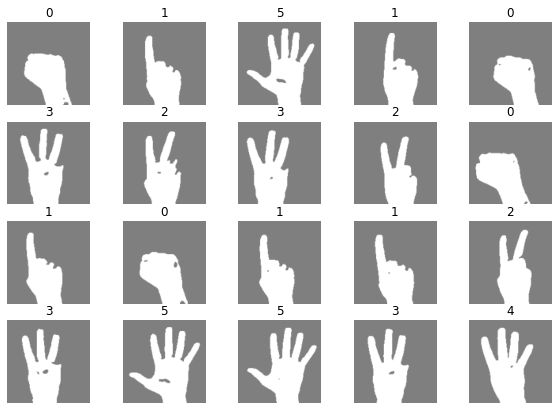

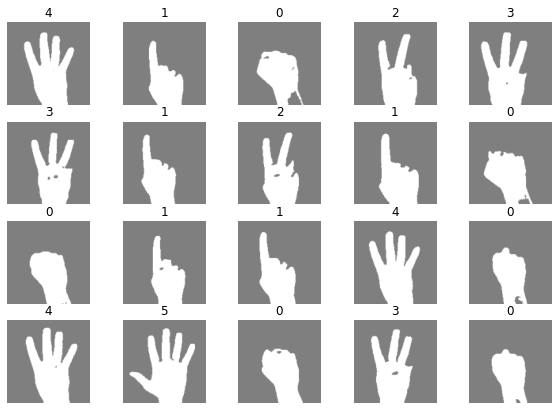

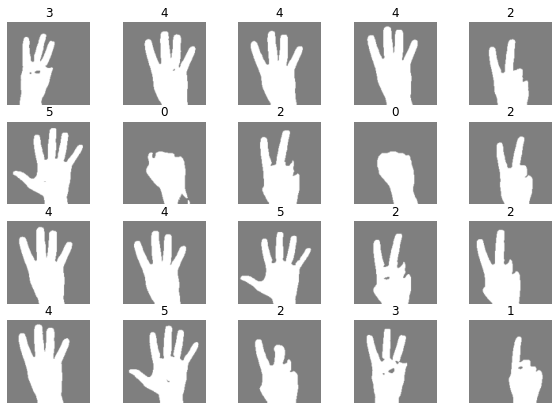

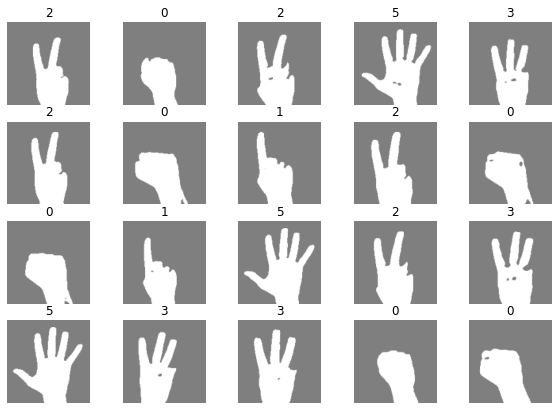

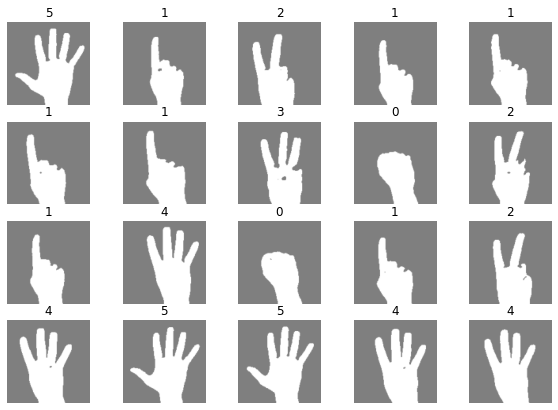

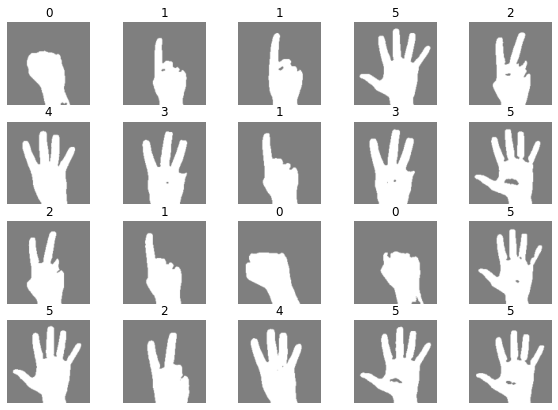

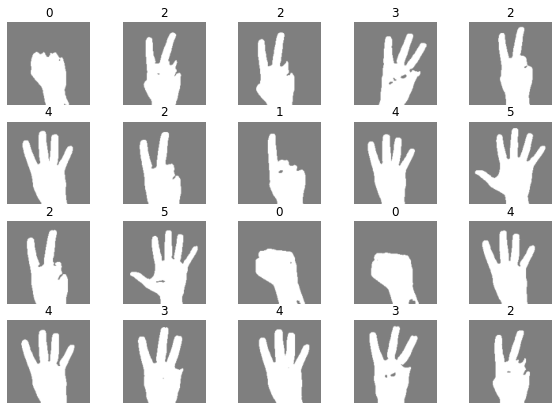

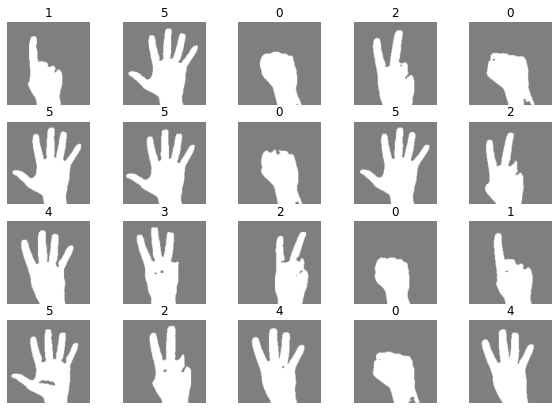

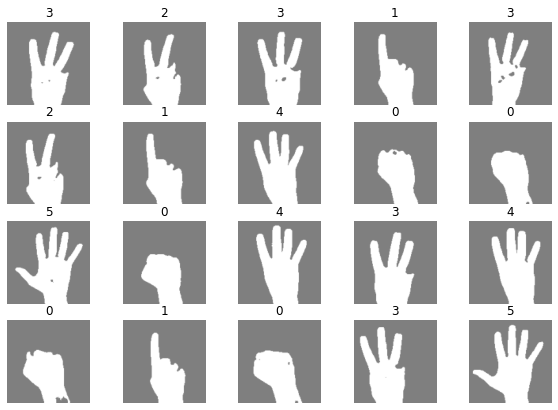

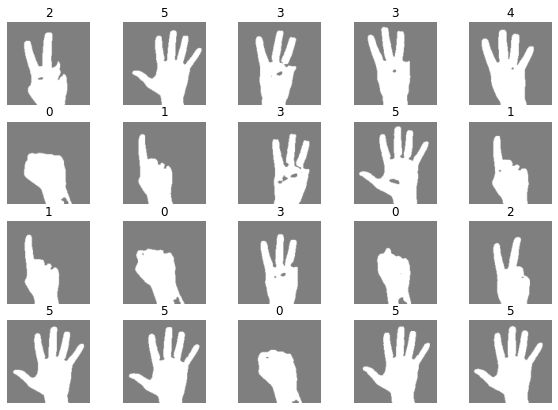

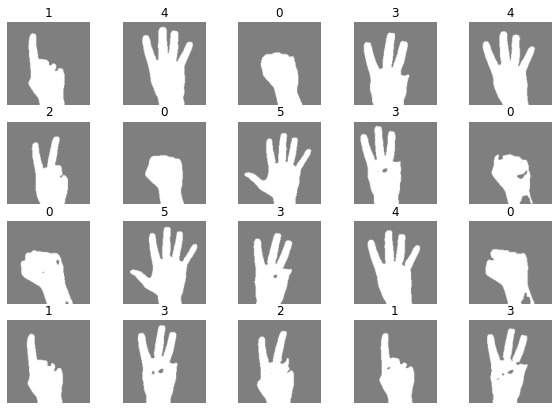

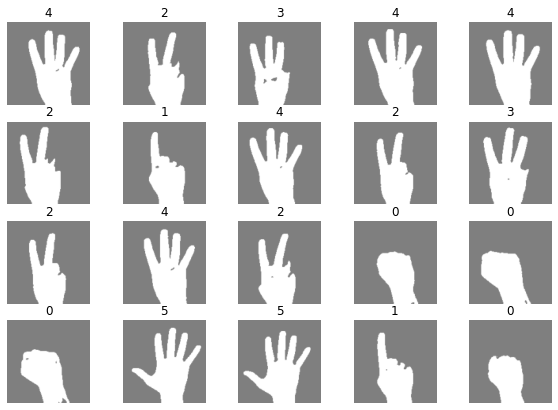

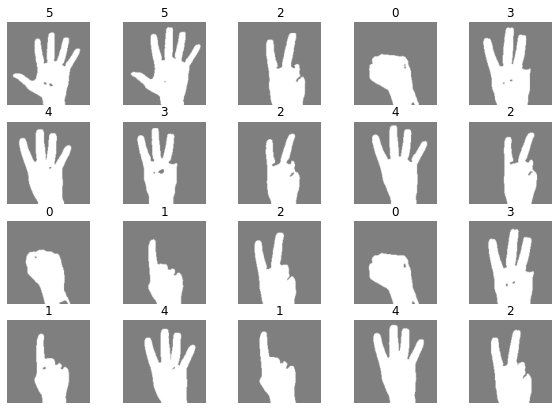

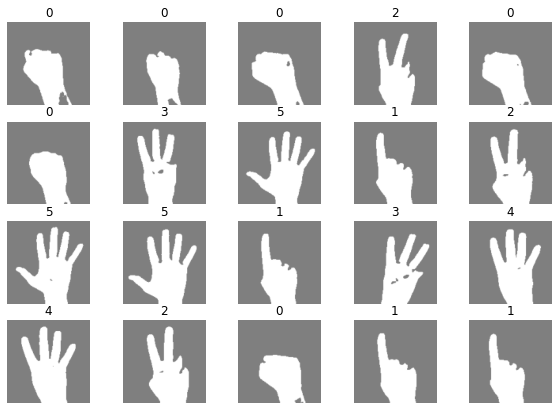

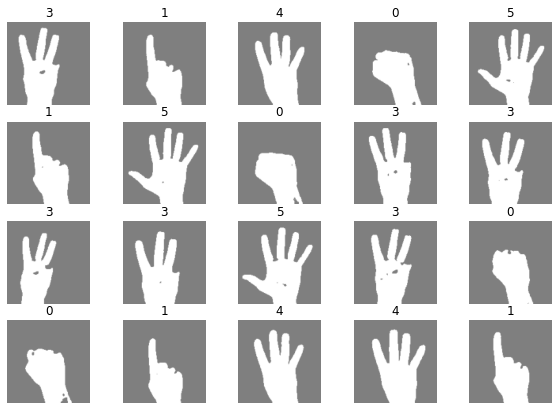

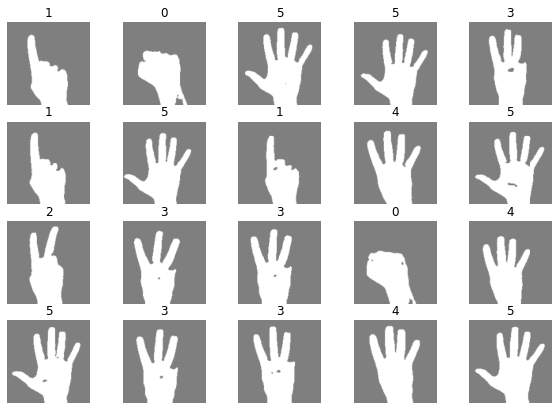

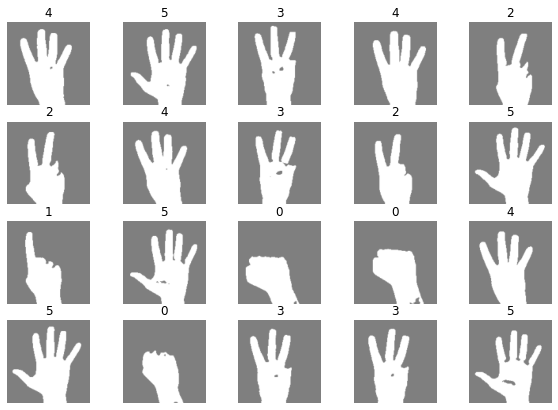

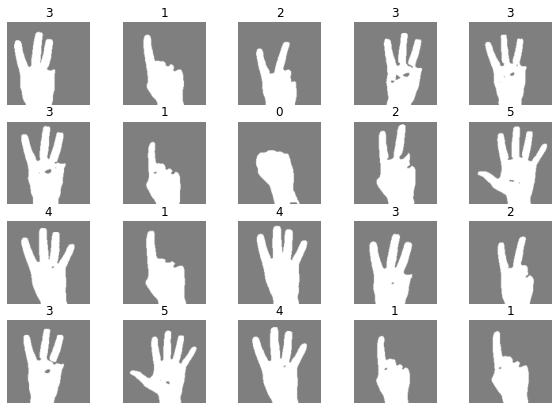

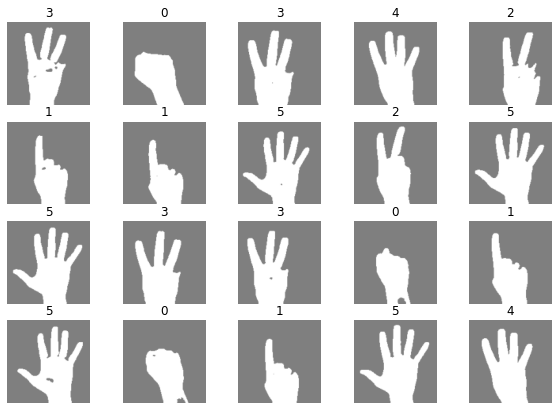

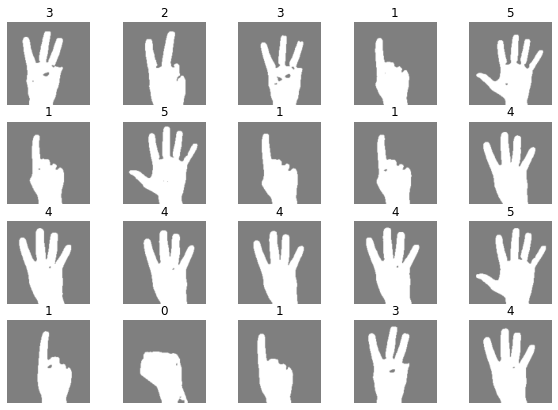

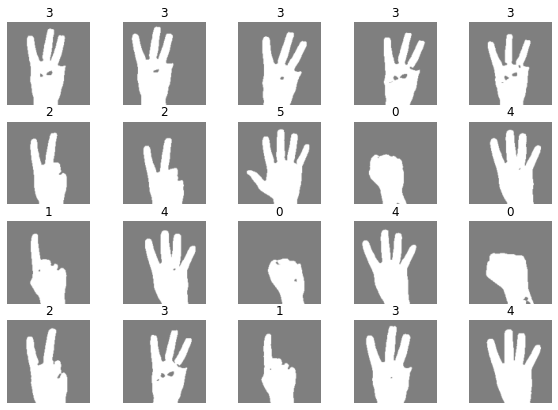

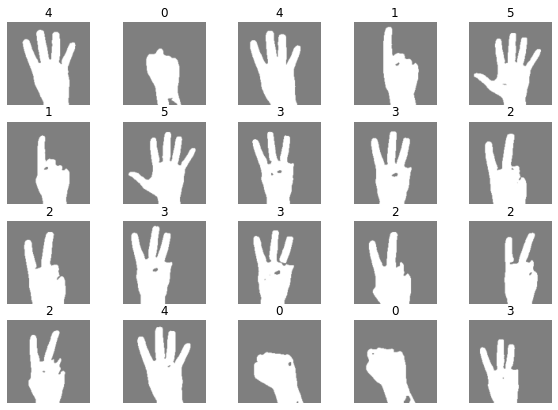

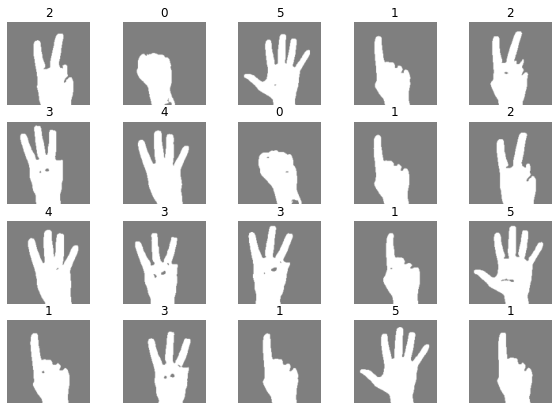

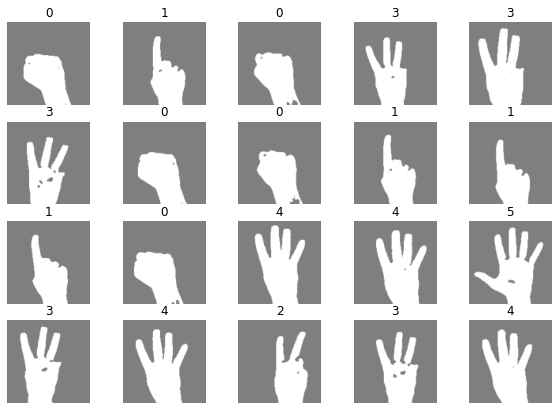

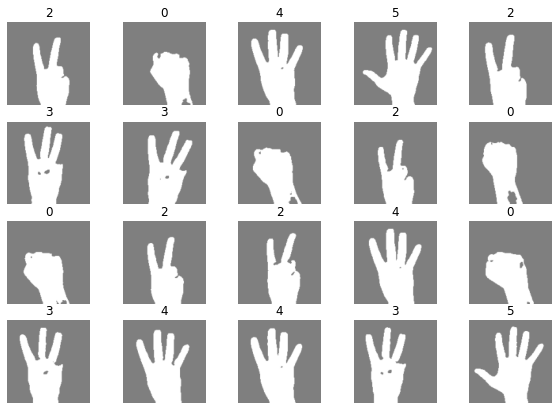

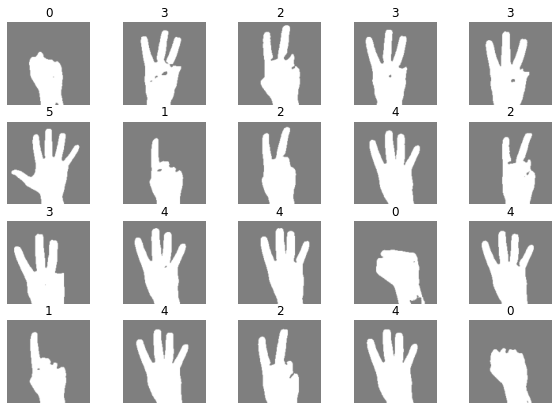

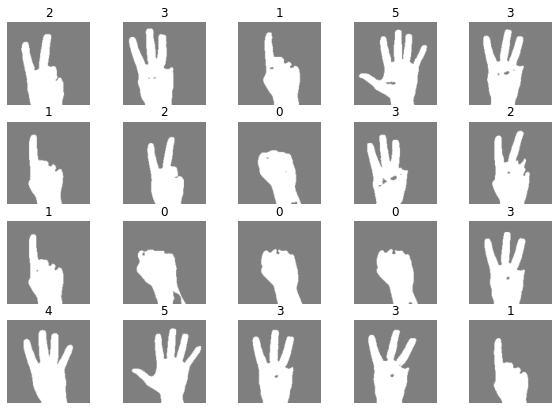

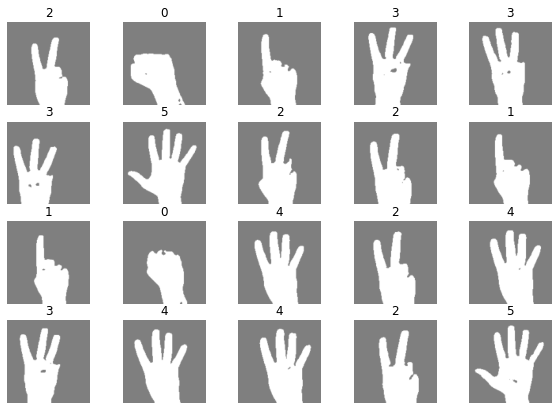

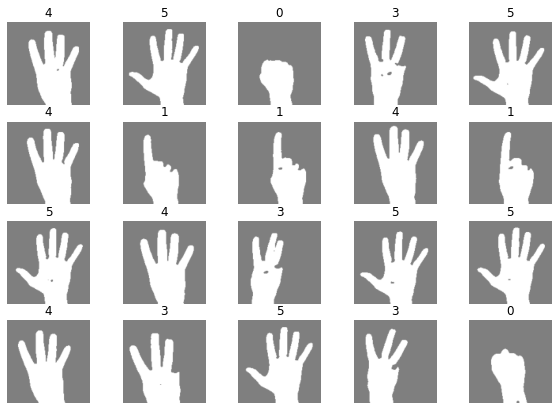

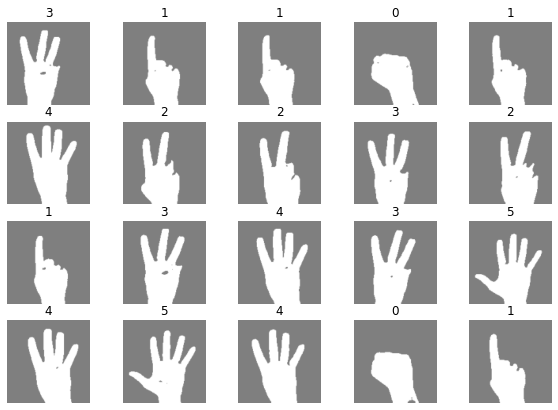

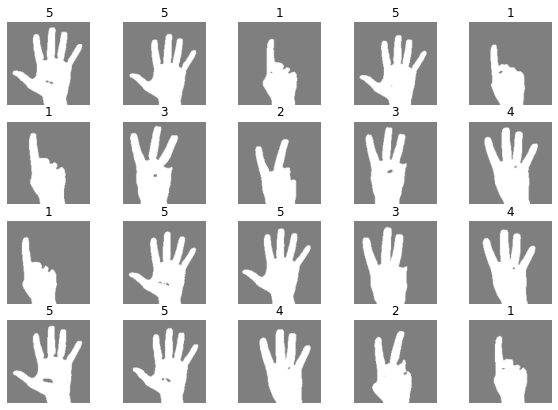

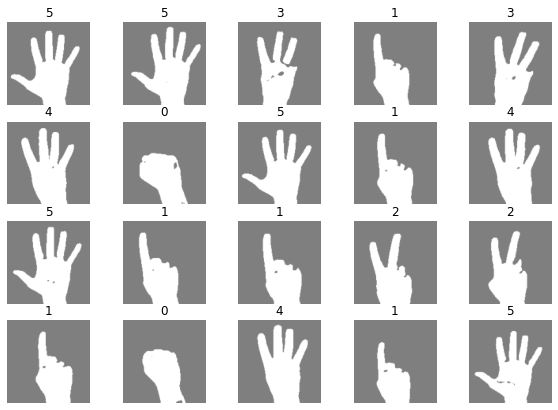

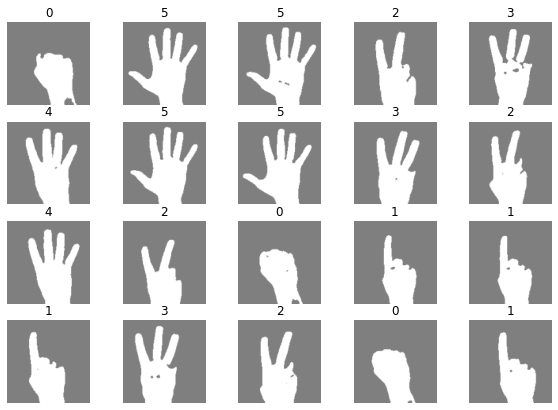

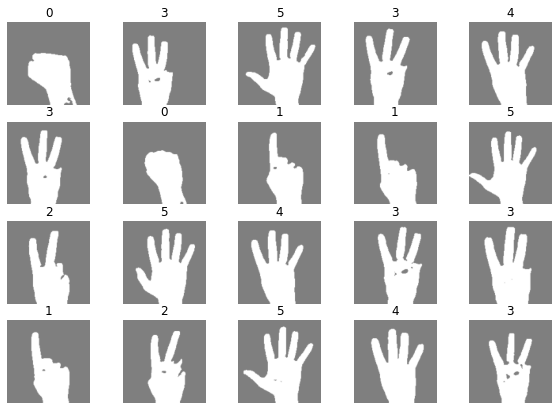

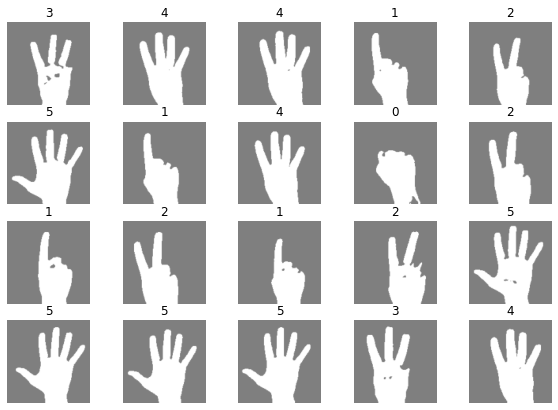

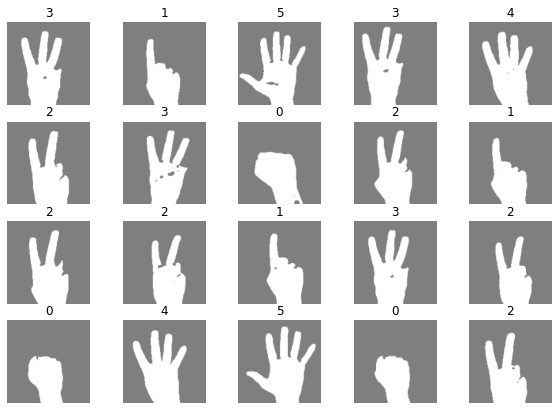

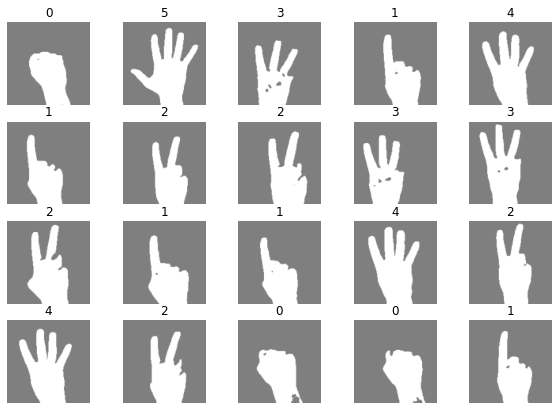

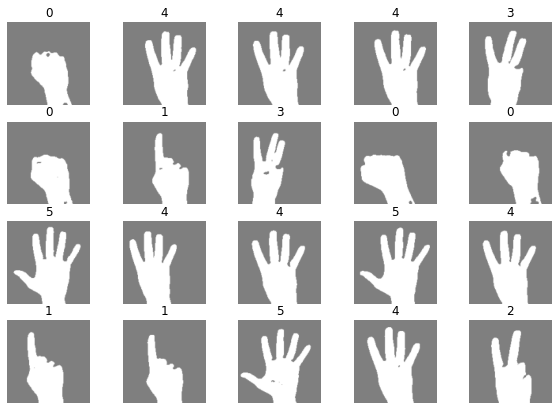

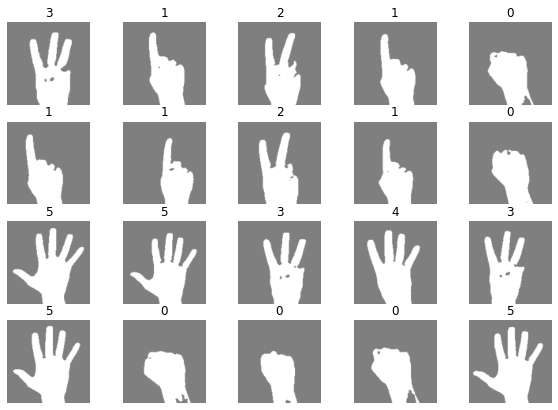

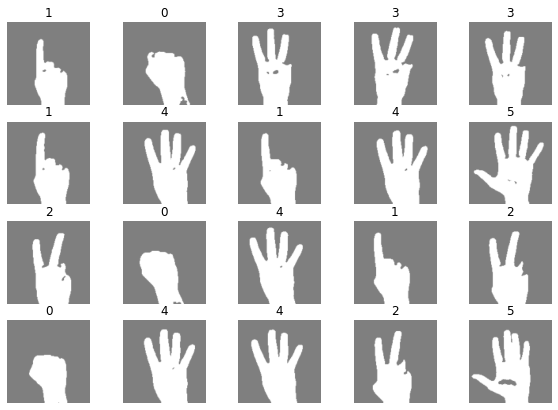

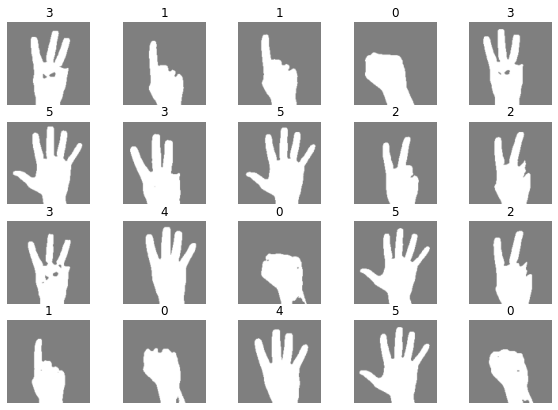

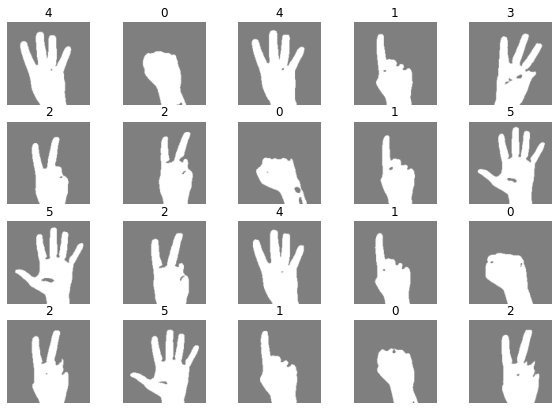

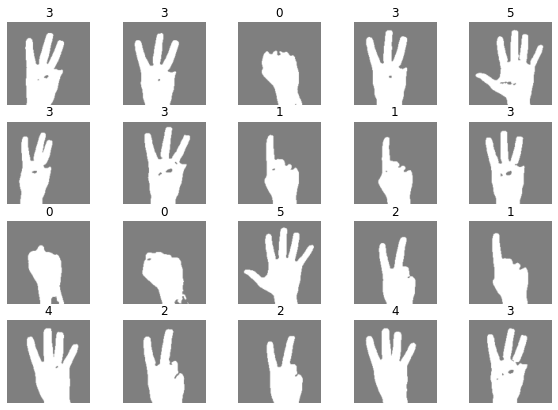

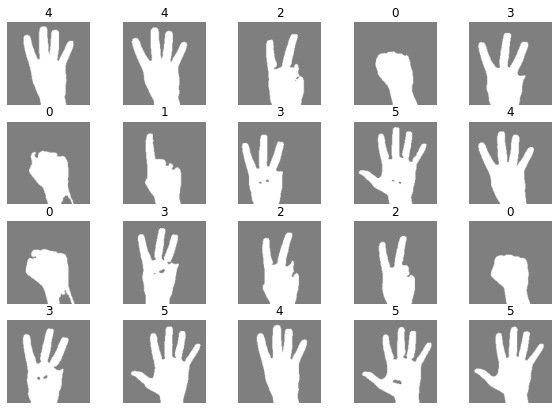

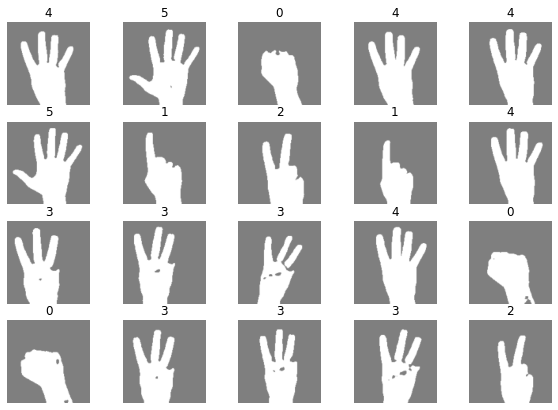

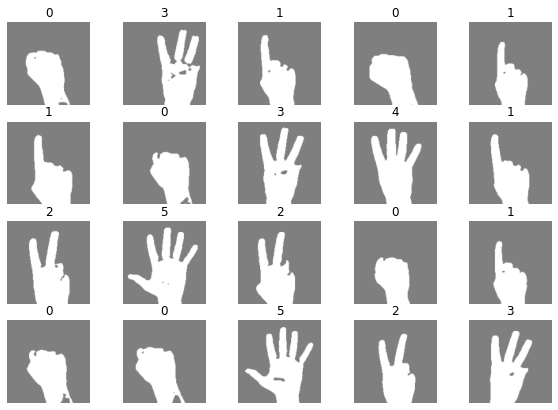

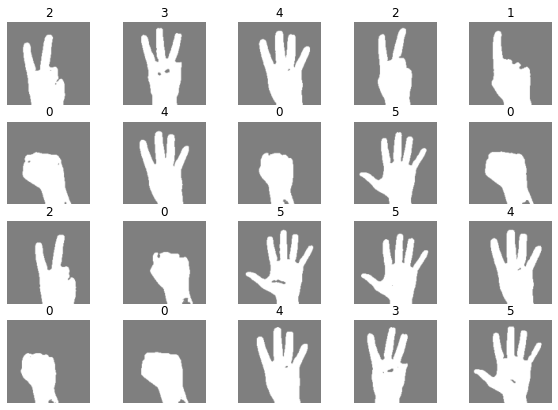

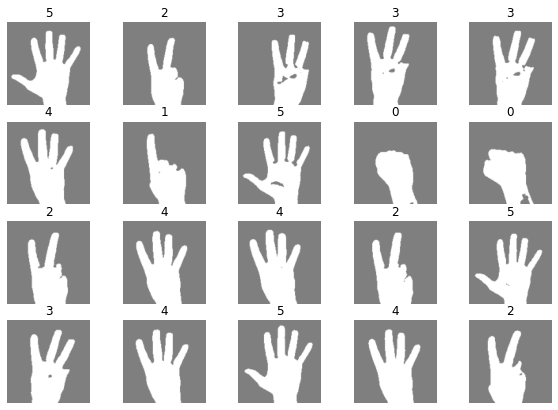

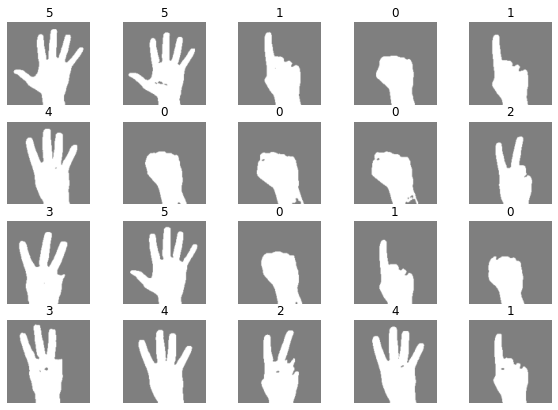

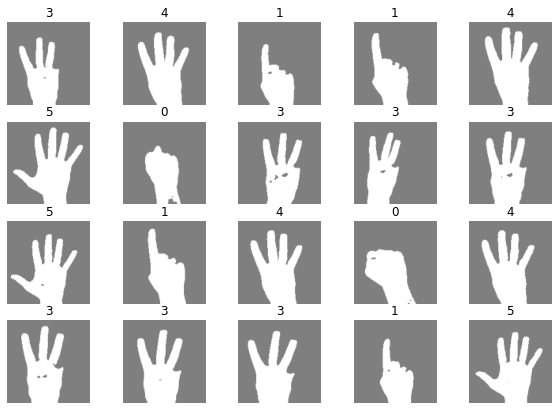

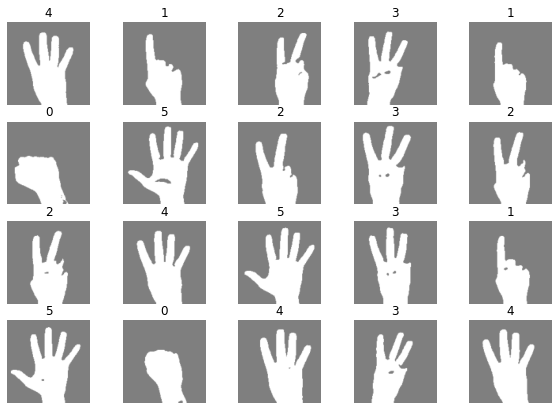

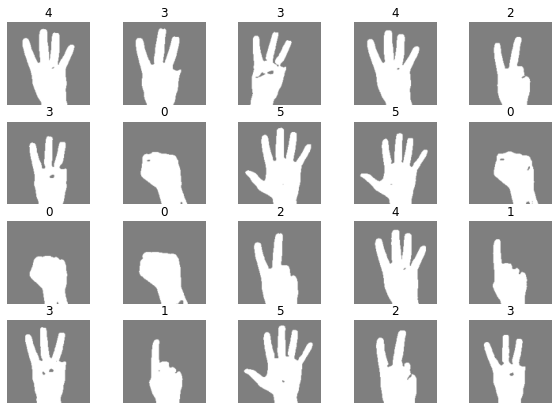

ValueError: ignored

<Figure size 720x504 with 0 Axes>

In [58]:
model = vgg19(pretrained=True).to(device)
for p in model.features.parameters():
    p.requires_grad = False

in_features = model.classifier[-4].in_features
last_layer = nn.Linear(in_features=in_features, out_features=n_class).to(device)
model.classifier[-1] = last_layer



test_set = FingerNumber(path_test, trans)
model.load_state_dict(torch.load("./vgg19.pt")["model"])
test_data_loader = DataLoader(test_set, 20, drop_last=False)

files_names = []
preds_names = []
for file_names, img, _ in test_data_loader:
    img = img.to(device)
    pred = model(img)
    
    labels = pred.argmax(1).cpu().detach().numpy()
    show_tensor_images(img, labels)
